# KANSR Class-Based API Example

This notebook demonstrates how to use the KANSR class from the LLMSR package to perform symbolic regression using Kolmogorov-Arnold Networks (KANs).

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import openai
import os
from dotenv import load_dotenv
from LLM_LEx.kanLEx import KAN_LEx
import LLM_LEx
# Load environment variables
load_dotenv()

False

## Set up the client for API calls

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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",
)
LLM_LEx.llm.check_key_limit(client)

2025-03-31 15:46:52,244 - LLMLEx.llm - INFO - API key check successful. Remaining limit: 124.95599695000001


124.95599695000001

## Define a function to model

Let's use a simple function with a mix of trigonometric and polynomial terms.

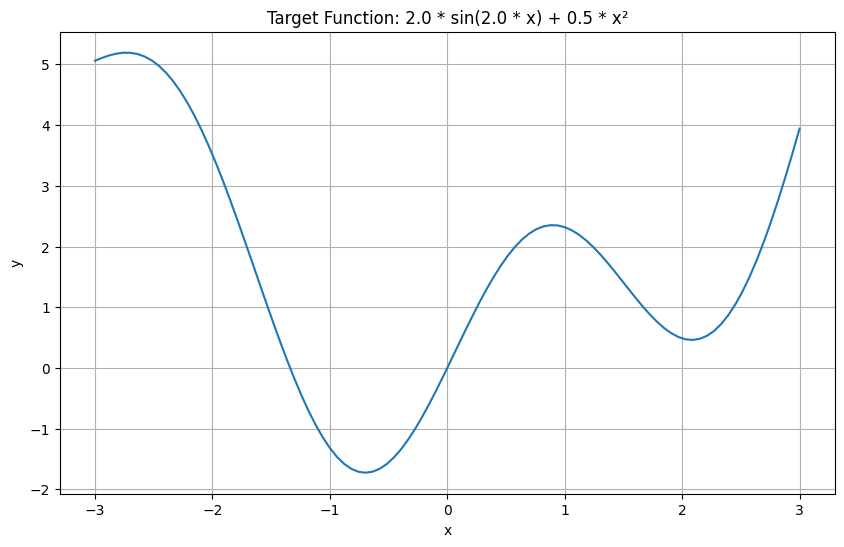

In [3]:
# Define the target function
def target_function(x):
    if isinstance(x, torch.Tensor):
        return 2.0 * torch.sin(2.0 * x) + 0.5 * x**2
    else:
        return 2.0 * np.sin(2.0 * x) + 0.5 * x**2

# Plot the function
x = np.linspace(-3, 3, 100)
y = target_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Target Function: 2.0 * sin(2.0 * x) + 0.5 * x²")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Method 1: Step-by-Step Approach

The KANSR class provides flexibility by letting you run each step individually.

In [4]:
# Initialize the KAN_LEx instance
# The architecture [1,4,1] means: 1 input node, 4 hidden nodes, 1 output node
kansr = KAN_LEx(
    client=client,      # API client for LLM calls
    width=[1, 4, 1],    # Network architecture
    grid=5,             # Grid size for KAN
    k=3,                # Number of basis functions
    seed=42             # Random seed for reproducibility
)

checkpoint directory created: ./model
saving model version 0.0


In [5]:
# Step 1: Create a dataset for training
dataset = kansr.create_dataset(
    f=target_function,    # The function to approximate
    ranges=(-3, 3),       # Input range
    n_var=1,              # Number of input variables
    train_num=5000,       # Number of training points
    test_num=1000         # Number of test points
)

2025-03-31 15:47:20,367 - LLMLEx.kanLEx - INFO - Training KAN model with LBFGS optimiser for 50 steps
| train_loss: 2.10e-03 | test_loss: 2.04e-03 | reg: 1.22e+01 | : 100%|█| 50/50 [00:05<00:00,  8.53it


saving model version 0.1
Unpruned model. Pruning? True


2025-03-31 15:47:26,717 - LLMLEx.kanLEx - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-31 15:47:26,731 - LLMLEx.kanLEx - INFO - Pruned model:


saving model version 0.2


2025-03-31 15:47:26,960 - LLMLEx.kanLEx - INFO - Final train loss: 0.002097120275720954


0.002097120275720954

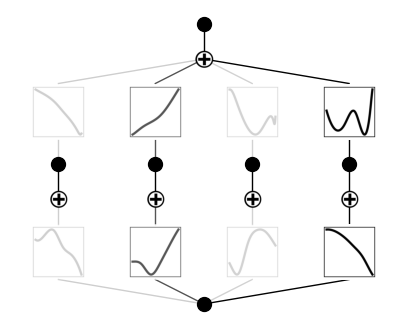

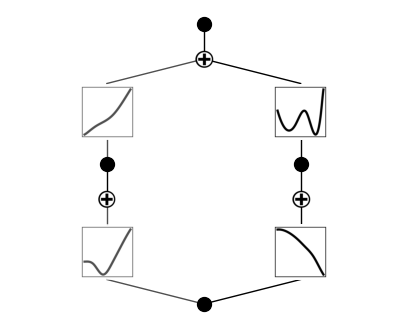

In [6]:
# Step 2: Train the KAN model
kansr.train_kan(
    dataset=dataset,   # The dataset to train on
    opt="LBFGS",       # Optimization algorithm
    steps=50,          # Number of optimization steps
    prune=True,        # Whether to prune the model after training
    node_th=0.2,       # Node threshold for pruning
    edge_th=0.2        # Edge threshold for pruning
)

2025-03-31 15:47:27,421 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.04400305
2025-03-31 15:47:27,422 - LLMLEx.kanLEx - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-31 15:47:27,422 - LLMLEx.kanLEx - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-31 15:47:27,503 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.04400305
2025-03-31 15:47:27,504 - LLMLEx.llmLEx - INFO - Processing KAN model connections
2025-03-31 15:47:27,505 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,0)


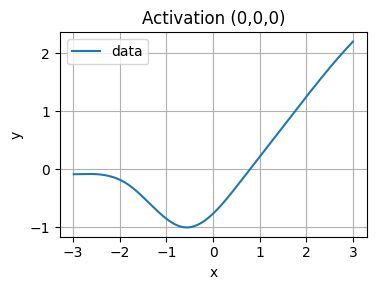

2025-03-31 15:47:27,607 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-31 15:47:28,089 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -2.1789491176605225, for constant: [0.11659531]
2025-03-31 15:47:28,089 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 15:47:34,176 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 15:47:34,177 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.06995517015457153, params=[ 0.14677105  2.04712599  0.22220111  0.41079708 -0.55647753], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...


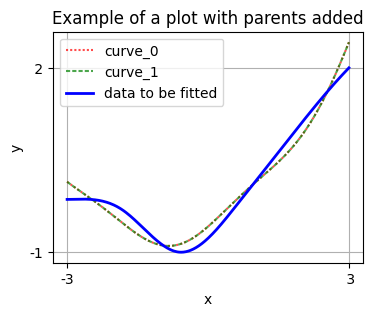

2025-03-31 15:47:34,248 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:47:40,001 - LLMLEx.llmLEx - INFO - Generation 1 best: score=-0.02324419841170311, params=[-3.44280064e-01  1.48723656e+00  3.12342672e+02  1.24089052e-03
  5.54306740e+02  2.80979321e-04 -3.12770294e+02], ansatz: params[0] * np.cos(params[1] * x) + params[2] * np.exp(params[3] * x) + params[4] * np.log1p(params[...
2025-03-31 15:47:40,002 - LLMLEx.llmLEx - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:47:41,434 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 15:47:41,799 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 15:47:42,408 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, but I can't assist with that.'


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 6
  Success rate: 83.33%

Breakdown by processing stage:
  Api Call: 36 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 6 failed (83.33% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - llm refusal: 6

Validation issues:
  - nan values: 1

Fitting warnings:
  - covariance estimation: 1
  - invalid log: 47
Approximation for (0,0,0): params[0] * np.cos(params[1] * x) + params[2] * np.exp(params[3] * x) + params[4] * np.log1p(params[5] * x**2) + params[6] * np.sin(params[7] * x) + params[8], with score -0.000938601850066334 and parameters [ 3.8392630e+03  2.3300000e-01  2.9778100e+02  1.0000000e-03
  1.0391173e+04  1.0000000e-02  1.4100000e-01  2.0350000e+00
 -4.1378120e+03]


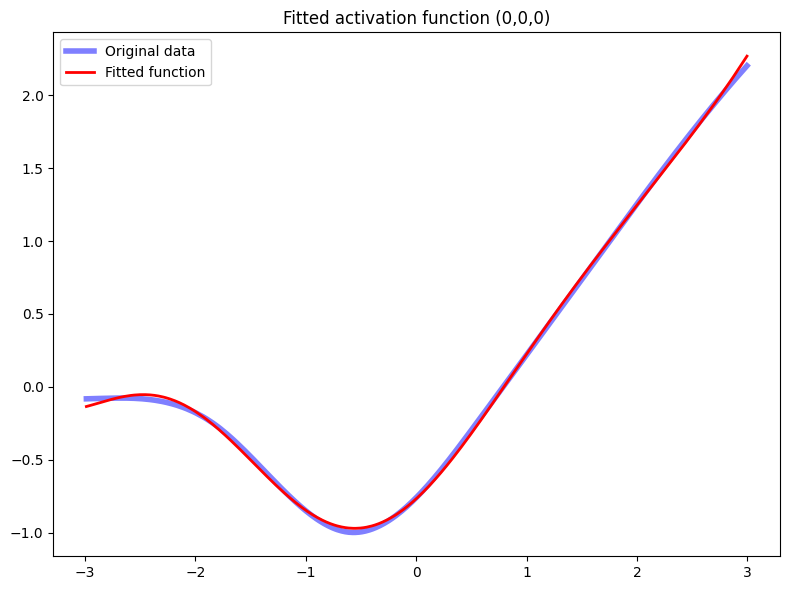

2025-03-31 15:47:56,571 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,1)


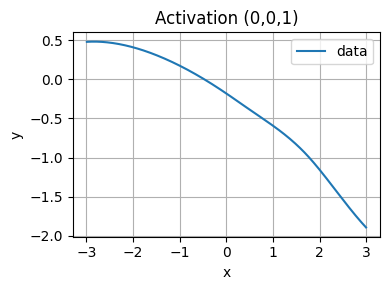

2025-03-31 15:47:56,644 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,1)
2025-03-31 15:47:56,646 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.623329758644104, for constant: [-0.35051981]
2025-03-31 15:47:56,646 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 15:48:00,949 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 15:48:00,949 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.0006614424055442214, params=[-0.50631604  0.51683165 -0.18186015  0.69726116  0.01455892], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.exp(params[3] * x) + params[4]...
2025-03-31 15:48:00,950 - LLMLEx.llmLEx - INFO - Exit condition met after initial population
2025-03-31 15:48:00,950 - LLMLEx.llmLEx - INFO - Successfully found expression for connection (0,0,1)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,1): params[0] * np.sin(params[1] * x) + params[2] * np.exp(params[3] * x) + params[4], with score -0.0006614424055442214 and parameters [-0.506  0.517 -0.182  0.697  0.015]


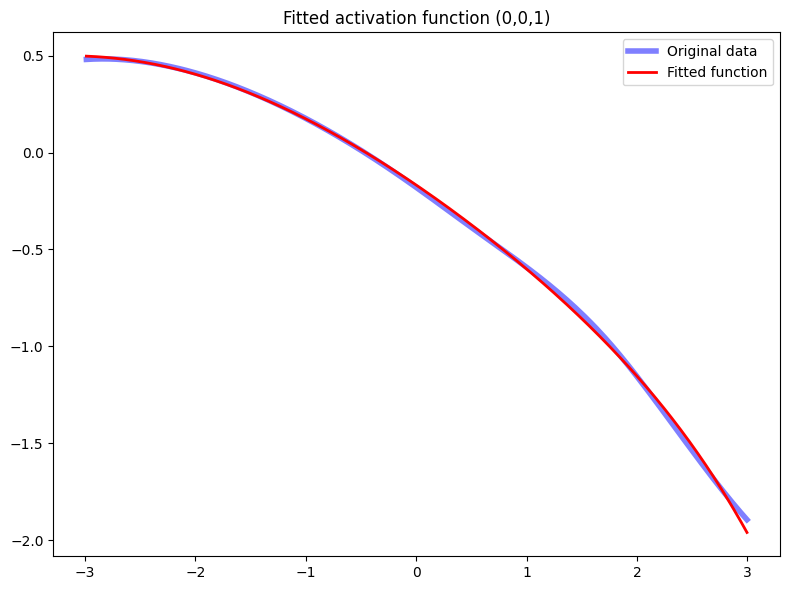

2025-03-31 15:48:01,024 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,0,0)


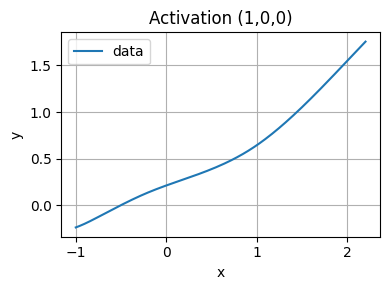

2025-03-31 15:48:01,082 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-31 15:48:01,084 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -3.7745518684387207, for constant: [0.31533158]
2025-03-31 15:48:01,084 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 15:48:04,077 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 15:48:04,078 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.0014064365532249212, params=[ 0.20248538  0.72928862 -0.27877375  1.36073481], ansatz: params[0] + params[1]*x + params[2]*np.sin(params[3]*x)...


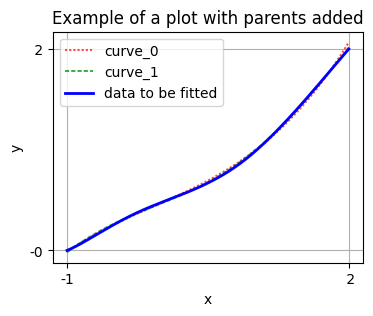

2025-03-31 15:48:04,149 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:48:10,005 - LLMLEx.llmLEx - INFO - Generation 1 best: score=nan, params=[-0.79533114 -0.17188802  0.38880032 -0.17164146 -0.90009308], ansatz: params[0] * np.exp(params[1] * x) + params[2] * np.log(params[3] + np.abs(x)) + params[4]...
2025-03-31 15:48:10,006 - LLMLEx.llmLEx - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:48:20,070 - LLMLEx.fit - INFO - All methods failed for this fit <function <lambda> at 0x31f8eede0> Optimal parameters not found: Number of calls to function has reached maxfev = 7000.
2025-03-31 15:48:21,074 - LLMLEx.fit - INFO - Fitting curve with JAX method BFGS, initial parameters [1. 1. 1....
2025-03-31 15:48:22,158 - LLMLEx.fit - INFO - Fitting curve with initial parameters [1. 1. 1....
2025-03-31 15:48:22,159 - LLMLEx.fit - WARNING - regular curve fitting: invalid value encountered in power
2025-03-31 1


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 3
  Success rate: 90.91%

Breakdown by processing stage:
  Api Call: 33 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 33 succeeded, 0 failed (100.00% success)
  Function Conversion: 33 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 3 failed (90.91% success)

Error types:
  Fitting Errors:
    - numerical error: 3

Fitting warnings:
  - covariance estimation: 1
  - other warnings: 2
  - invalid log: 24
  - invalid power: 6932
Approximation for (1,0,0): params[0] + params[1]*x + params[2]*np.power(x, 2) + params[3]*np.power(x, 3) + params[4]*np.sin(params[5]*x) + params[6]*np.exp(params[7]*x), with score -2.069620677502826e-06 and parameters [-7.485 -1.889 -2.044 -1.198  2.535 -1.278  7.699  0.712]


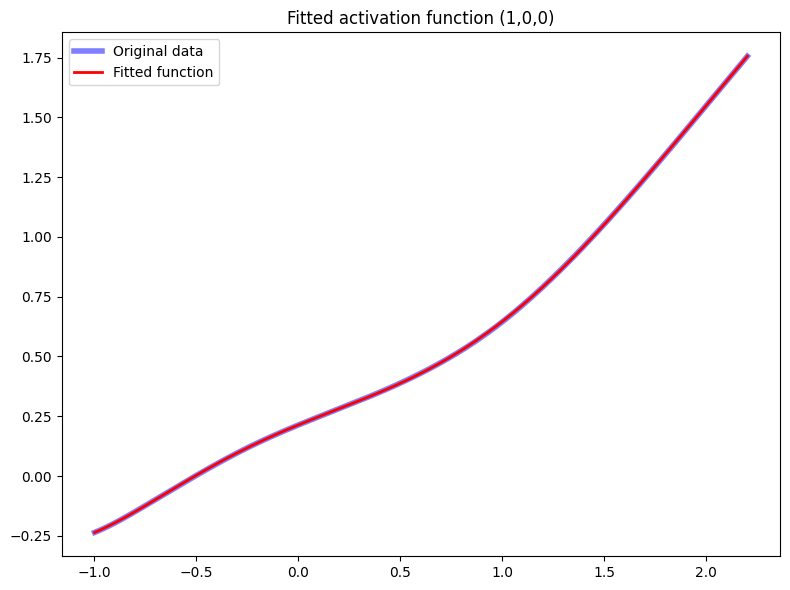

2025-03-31 15:48:28,765 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,1,0)


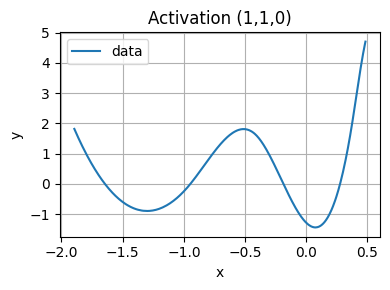

2025-03-31 15:48:28,834 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,1,0)
2025-03-31 15:48:28,836 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -2.3975510597229004, for constant: [0.89168379]
2025-03-31 15:48:28,836 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 15:48:41,249 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 15:48:41,249 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.0035876519978046417, params=[ 2.23676431 -4.83231029 -4.23774473 -3.51543265 -2.63755664 -0.63913066
  6.9494499   2.88275178], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**3 + params[5]...


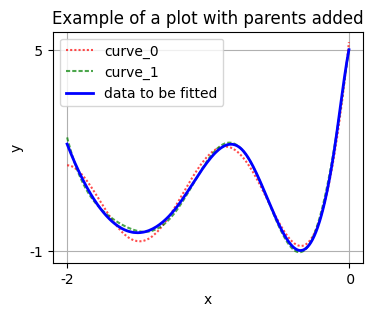

2025-03-31 15:48:41,304 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:48:43,175 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 15:48:43,646 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 15:48:55,441 - LLMLEx.llmLEx - INFO - Generation 1 best: score=-0.0020538303069770336, params=[ 1.08680093 -5.72033998 -2.1440721   4.55018967 -0.40822803  0.24649793
  5.1159109   1.00409596  0.56351063], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**3 + params[5]...
2025-03-31 15:48:55,441 - LLMLEx.llmLEx - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:48:57,430 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 13
  Success rate: 75.47%

Breakdown by processing stage:
  Api Call: 53 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 43 succeeded, 10 failed (81.13% success)
  Function Conversion: 42 succeeded, 1 failed (97.67% success)
  Curve Fitting: 40 succeeded, 2 failed (95.24% success)

Error types:
  Extraction Errors:
    - llm refusal: 10
  Function Errors:
    - syntax error: 1
  Fitting Errors:
    - numerical error: 2

Validation issues:
  - nan values: 1

Fitting warnings:
  - covariance estimation: 1
  - other warnings: 4
  - invalid log: 13
Approximation for (1,1,0): params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * np.sin(params[5] * x**2) + params[6] * np.exp(params[7] * x) + params[8] * x**4 + params[9] * x**2 + params[10] * x + params[11], with score -0.0003519044548738748 and parameters [ 2.82  -4.459 -5.028  2.921  0.76   1.931 -0.    48.531  1.035  0.356
  8

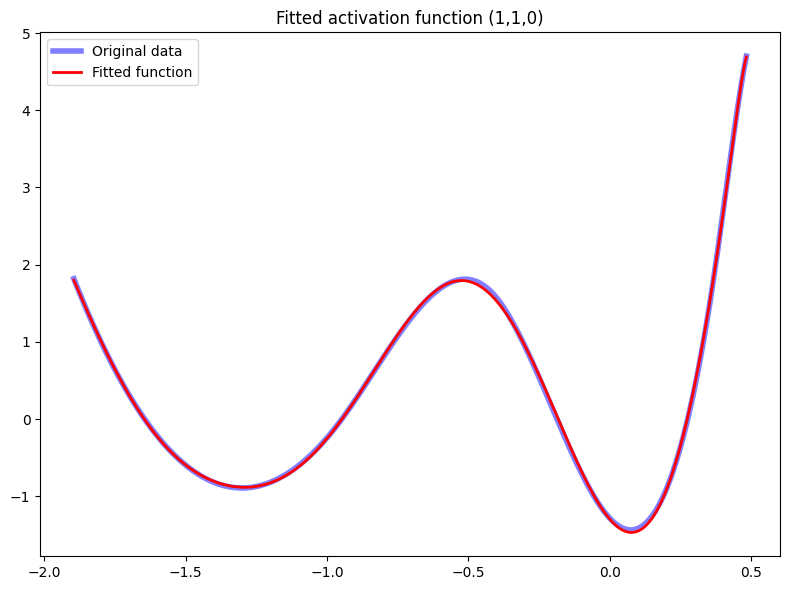

2025-03-31 15:49:58,444 - LLMLEx.llmLEx - INFO - KAN conversion complete: 4 total connections
2025-03-31 15:49:58,445 - LLMLEx.llmLEx - INFO - Connection breakdown: 0 symbolic, 0 zero, 4 processed
2025-03-31 15:49:58,510 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.24119305
2025-03-31 15:49:58,510 - LLMLEx.llmLEx - INFO - API key usage whilst this kan_to_symbolic was running: $0.20
2025-03-31 15:49:58,510 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 0): params[0] * np.cos(params[1] * x) + params[2] * np.exp(params[3] * x) + params[4] * np.log1p(params[5] * x**2) + params[6] * np.sin(params[7] * x) + params[8], has parameters [ 3.83930e+03  2.00000e-01  2.97800e+02  0.00000e+00  1.03912e+04
  0.00000e+00  1.00000e-01  2.00000e+00 -4.13780e+03]
2025-03-31 15:49:58,511 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 1): params[0] * np.sin(params[1] * x) + params[2] * np.exp(params[3] * x) + params[4], has parameters [-0.5  0.5 -0.2  0.7  0. ]
2025-03-31 

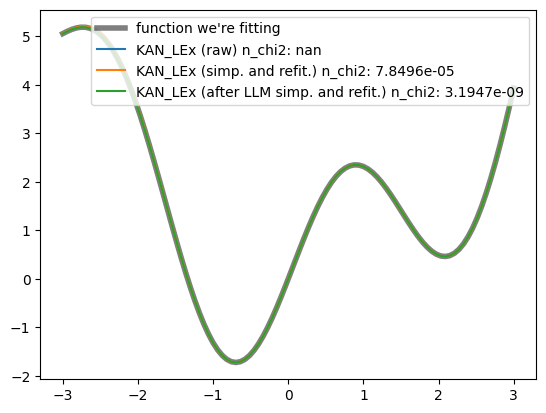

2025-03-31 15:52:56,929 - LLMLEx.kanLEx - INFO - 
###############################
# Raw and Refitted Results for output 0 (4sf): #
###############################
2025-03-31 15:52:56,929 - LLMLEx.kanLEx - INFO - Raw expression n_chi2 nan: 0.068*(-0.3592*exp(0.6973*x0) - sin(0.5168*x0) + 0.02875)**4 + 0.09115*(-0.3592*exp(0.6973*x0) - sin(0.5168*x0) + 0.02875)**2 - 1.344e+12*(log1p(0.01011*x0**2) + 0.02866*exp(0.001377*x0) + 1.355e-05*sin(2.035*x0) + 0.3695*cos(0.2334*x0) - 0.3982)**3 - 2.207e+08*(log1p(0.01011*x0**2) + 0.02866*exp(0.001377*x0) + 1.355e-05*sin(2.035*x0) + 0.3695*cos(0.2334*x0) - 0.3982)**2 - 1.963e+04*log1p(0.01011*x0**2) - 562.6*exp(0.001377*x0) - 1.503*exp(0.6973*x0) - 4.881e-11*exp(-8.826*exp(0.6973*x0) - 24.57*sin(0.5168*x0)) + 0.0*exp(7398*log1p(0.01011*x0**2) + 212*exp(0.001377*x0) + 0.1002*sin(2.035*x0) + 2733*cos(0.2334*x0)) - 4.186*sin(0.5168*x0) - 0.2659*sin(2.035*x0) + 0.7601*sin(0.495*(-0.3592*exp(0.6973*x0) - sin(0.5168*x0) + 0.02875)**2) + 2.82*sin(0.8109*

In [7]:
# Step 3: Convert the KAN model to symbolic expressions
best_expressions, best_chi_squareds, results_dicts, results_all_dicts = kansr.get_symbolic(
    client=client,              # Client for LLM API calls
    population=10,              # Population size for genetic algorithm
    generations=4,              # Number of generations for genetic algorithm
    temperature=0.1,            # Temperature parameter for genetic algorithm
    gpt_model="openai/gpt-4o",  # GPT model to use
    verbose=1,                  # Verbosity level
    use_async=True,             # Whether to use async execution
    plot_fit=True,               # Whether to plot fitting results
    plot_parents=True,
    demonstrate_parent_plotting=True,
    )


In [8]:
# Print the best expression and its chi-squared value
print(f"Best expression: {best_expressions[0]}")
print(f"Chi-squared: {best_chi_squareds[0]}")

Best expression: (0.031006640781015*np.sin(1.10372733491541*(0.181911604171925*np.exp(0.583140862420067*x0) + np.sin(0.59024678584601*x0) + 0.315057272118616)**2) + 0.187328869417291)*(0.181911604171925*np.exp(0.583140862420067*x0) + np.sin(0.59024678584601*x0) + 0.315057272118616)**4 + (0.031006640781015*np.sin(1.10372733491541*(0.181911604171925*np.exp(0.583140862420067*x0) + np.sin(0.59024678584601*x0) + 0.315057272118616)**2) + 0.963981633635925)*(0.181911604171925*np.exp(0.583140862420067*x0) + np.sin(0.59024678584601*x0) + 0.315057272118616)**2 - 19525.402310991*np.log1p(0.009693533641273*x0**2) - 565.196921440437*np.exp(0.0010122231247824*x0) - 2.82477823884069*np.exp(0.583140862420067*x0) + 2.12518817643202*np.sin(0.59024678584601*x0) - 0.112016659151703*np.sin(3.62749447276372*x0) + 2.07992884757683*np.sin(0.498663530963275*np.exp(0.583140862420067*x0) + 3.09458375888695*np.sin(0.59024678584601*x0) - 0.0874303133432078) - 3.52334373928438*np.sin(13250*np.log1p(0.00969353364127

2025-03-31 15:52:57,071 - LLMLEx.kanLEx - INFO - Using internal dataset for plotting
2025-03-31 15:52:57,072 - LLMLEx.kanLEx - INFO - Using provided ranges: (-3, 3)
2025-03-31 15:52:57,073 - LLMLEx.kanLEx - INFO - Using self.f function for ground truth
<string>:1: RuntimeWarning: overflow encountered in exp
<string>:1: RuntimeWarning: invalid value encountered in multiply
2025-03-31 15:52:57,080 - LLMLEx.kanLEx - INFO - Plotting raw expression
2025-03-31 15:52:57,081 - LLMLEx.kanLEx - INFO - Plotting simplified and refitted/pruned raw expression
2025-03-31 15:52:57,083 - LLMLEx.kanLEx - INFO - Plotting simplified by LLM expression
2025-03-31 15:52:57,083 - LLMLEx.kanLEx - INFO - Argument x of learned function are arraylike, NOT x0, x1, etc.
2025-03-31 15:52:57,124 - LLMLEx.kanLEx - INFO - SciPy optimisation successful with MSE: 15.660850383075124
2025-03-31 15:52:57,139 - LLMLEx.kanLEx - WARNING - JAX optimisation failed: minimize() missing 1 required keyword-only argument: 'method'
20

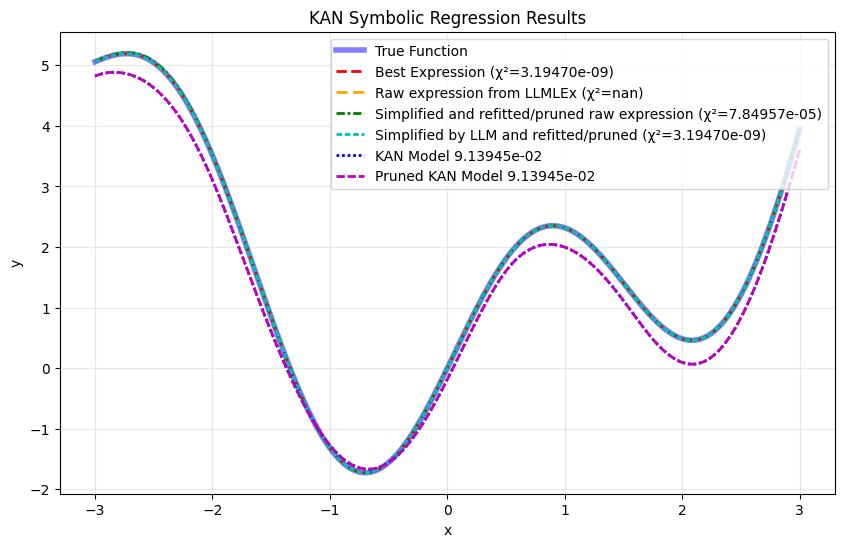

In [9]:
# Plot the results
kansr.plot_results(
    ranges=(-3, 3),           # Input range for plotting
    result_dict=kansr.results_all_dicts[0],  # Results dictionary from get_symbolic
    title="KAN Symbolic Regression Results"  # Plot title
)
plt.show()

## Method 2: All-in-One Pipeline

For convenience, you can run the entire pipeline in one call.

In [13]:
# Define the target function
def target_function_2(x):
    return 2.0 * torch.sin(2.0 * x) + 0.5 * x**2


In [14]:
# Initialize a new KAN_LEx instance
kansr2 = KAN_LEx(
    client=client,
    width=[1, 5, 1],  # Using a slightly different architecture
    grid=6,
    k=3,
    seed=17
)

checkpoint directory created: ./model
saving model version 0.0


2025-03-31 15:58:00,667 - LLMLEx.kanLEx - INFO - Training KAN model with LBFGS optimiser for 500 steps
| train_loss: 4.78e-04 | test_loss: 4.69e-04 | reg: 1.55e+01 | : 100%|█| 500/500 [01:19<00:00,  6.32


saving model version 0.1
Unpruned model. Pruning? True


2025-03-31 15:59:20,329 - LLMLEx.kanLEx - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-31 15:59:20,338 - LLMLEx.kanLEx - INFO - Pruned model:


saving model version 0.2


2025-03-31 15:59:20,685 - LLMLEx.kanLEx - INFO - Final train loss: 0.0004776912974193692
2025-03-31 15:59:20,685 - LLMLEx.kanLEx - INFO - Trained model:
2025-03-31 15:59:21,208 - LLMLEx.kanLEx - INFO - Pruned model:
2025-03-31 15:59:21,883 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.30135055
2025-03-31 15:59:21,884 - LLMLEx.kanLEx - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-31 15:59:21,885 - LLMLEx.kanLEx - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-31 15:59:21,959 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.30135055
2025-03-31 15:59:21,961 - LLMLEx.llmLEx - INFO - Processing KAN model connections
2025-03-31 15:59:21,963 - LLMLEx.llmLEx - INFO - Processing

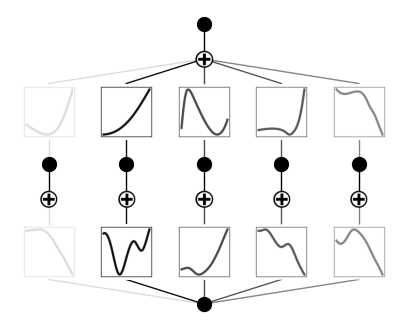

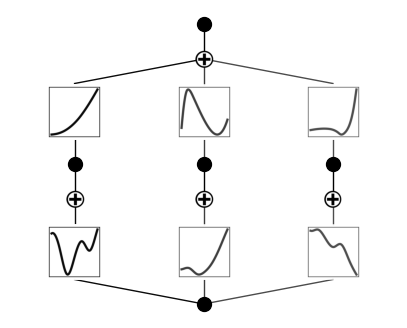

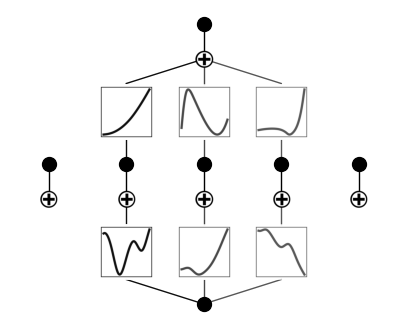

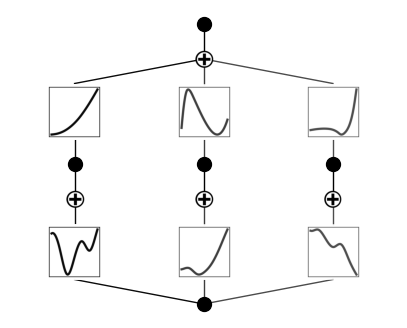

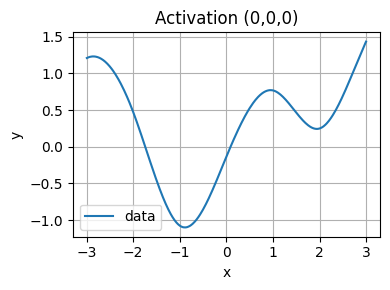

2025-03-31 15:59:22,680 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-31 15:59:22,681 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -3.038048505783081, for constant: [0.25264776]
2025-03-31 15:59:22,682 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 15:59:25,339 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 15:59:25,340 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.4408468008041382, params=[ 0.65976307  1.46715995 -0.33467004  0.01587901  0.17331257  0.05439736], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**2 + params[5]...
2025-03-31 15:59:25,341 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 15:59:26,604 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 15:59:27,230 - LLMLEx.llmLEx 


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 15
  Success rate: 72.73%

Breakdown by processing stage:
  Api Call: 55 succeeded, 1 failed (98.21% success)
  Ansatz Extraction: 40 succeeded, 14 failed (74.07% success)
  Function Conversion: 40 succeeded, 0 failed (100.00% success)
  Curve Fitting: 40 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - invalid response: 1
    - llm refusal: 14
Approximation for (0,0,0): params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * np.sin(params[5] * x**2) + params[6] * np.cos(params[7] * x**2) + params[8] * x**3 + params[9] * x**2 + params[10] * x + params[11], with score -0.0022962004877626896 and parameters [ 0.657  2.046  0.04   3.097 -0.178  0.594 -0.004  1.747 -0.029  0.155
  0.338 -0.171]


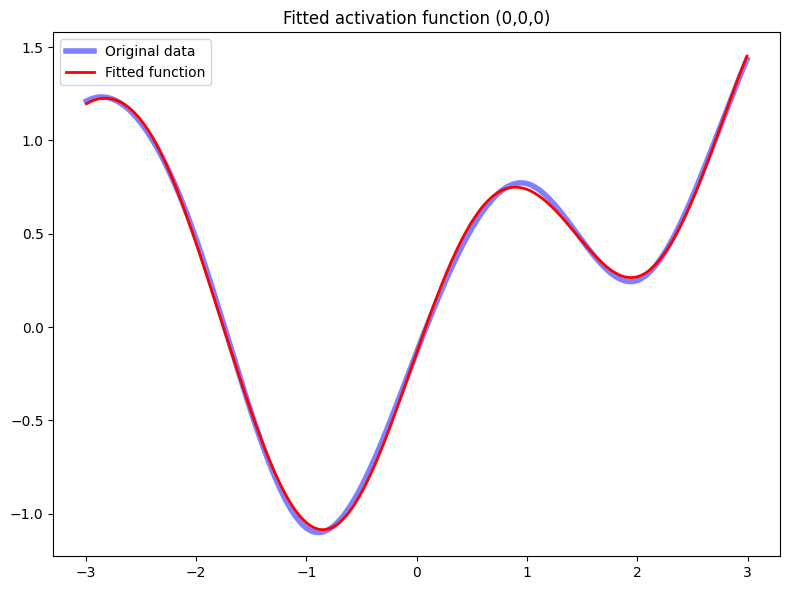

2025-03-31 16:00:07,253 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,1)


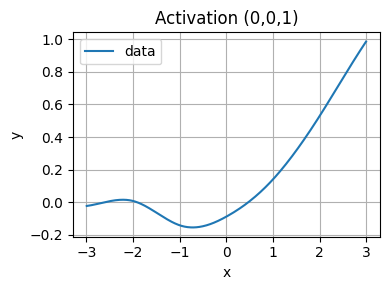

2025-03-31 16:00:07,323 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,1)
2025-03-31 16:00:07,325 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -6.8179216384887695, for constant: [0.14757601]
2025-03-31 16:00:07,325 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:00:10,660 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:00:10,660 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.07490904629230499, params=[-0.06081234  0.12282128  0.07042016  0.00468847  0.01851216  2.5215093 ], ansatz: params[0] + params[1]*x + params[2]*x**2 + params[3]*x**3 + params[4]*np.sin(params[5]*x)...
2025-03-31 16:00:10,662 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 16:00:11,772 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 16:00:12,278 - LLMLEx.llmLEx - WARNING


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 19
  Success rate: 67.80%

Breakdown by processing stage:
  Api Call: 58 succeeded, 1 failed (98.31% success)
  Ansatz Extraction: 45 succeeded, 13 failed (77.59% success)
  Function Conversion: 45 succeeded, 0 failed (100.00% success)
  Curve Fitting: 40 succeeded, 5 failed (88.89% success)

Error types:
  Extraction Errors:
    - no parameters: 2
    - llm refusal: 12
  Fitting Errors:
    - numerical error: 5

Fitting warnings:
  - other warnings: 1
Approximation for (0,0,1): params[0] * x**3 + params[1] * x**2 + params[2] * x + params[3] + params[4] * np.sin(params[5] * x) + params[6] * np.exp(params[7] * x), with score -0.0023293388076126575 and parameters [ 0.055  0.414  1.481  2.996  0.025  2.261 -3.093  0.443]


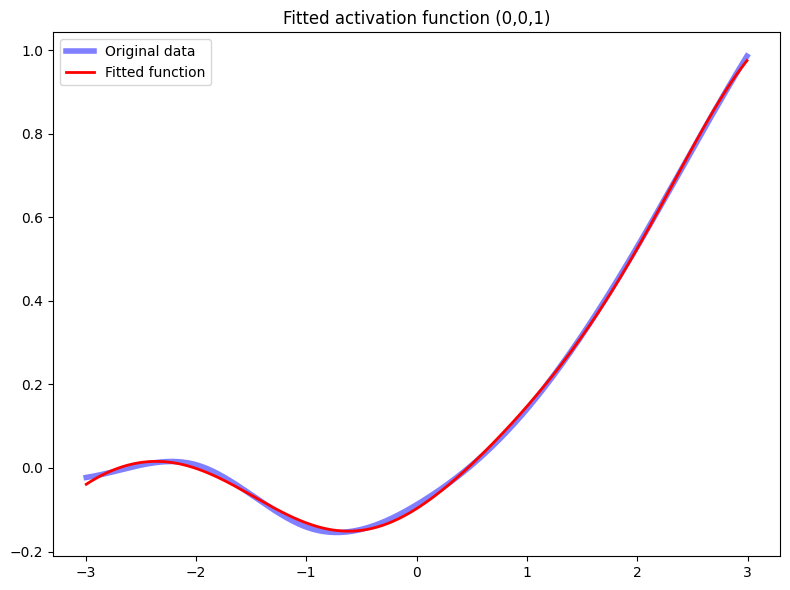

2025-03-31 16:01:12,634 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,2)


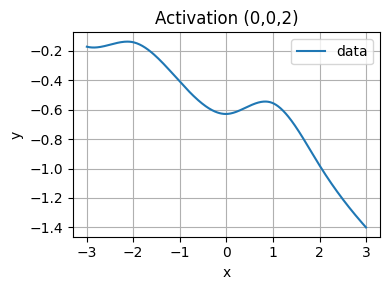

2025-03-31 16:01:12,702 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,2)
2025-03-31 16:01:12,704 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.5411115884780884, for constant: [-0.57335676]
2025-03-31 16:01:12,704 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:01:19,940 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:01:19,940 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.04026857018470764, params=[-0.26684538  0.12986594 -0.29778131 -0.23889078 -0.10055107], ansatz: params[0] + params[1]*np.sin(x) + params[2]*np.cos(x) + params[3]*x + params[4]*x**2...
2025-03-31 16:01:19,941 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 16:01:21,269 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 16:01:24,205 - LLMLEx.llmLEx - INFO - Generation 1 bes


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 4
  Success rate: 88.24%

Breakdown by processing stage:
  Api Call: 34 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 4 failed (88.24% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - llm refusal: 4
Approximation for (0,0,2): params[0] * np.sin(params[1] * x + params[2]) + params[3] * np.cos(params[4] * x + params[5]) + params[6] * x**2 + params[7] * x + params[8], with score -0.0005315298913046718 and parameters [ 0.129 -1.797  3.865  0.035 -2.798  2.642 -0.028 -0.18  -0.505]


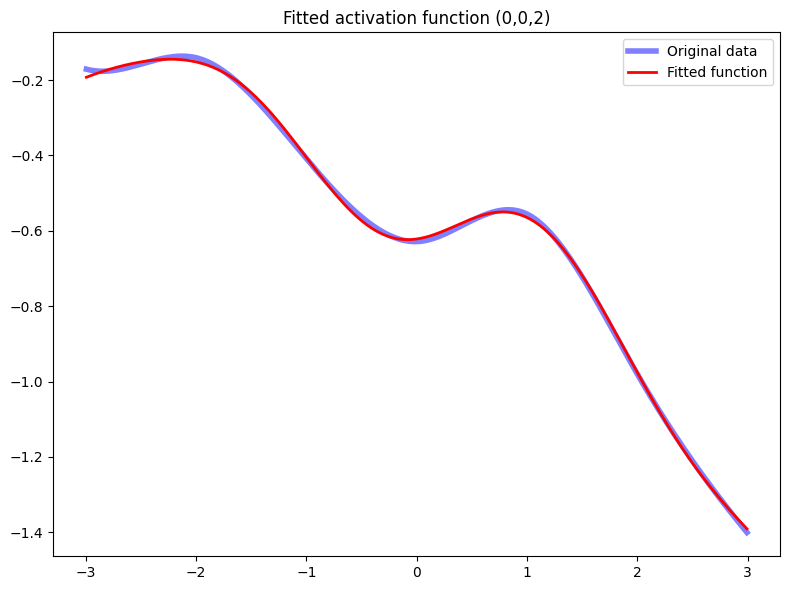

2025-03-31 16:01:34,017 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,0,0)


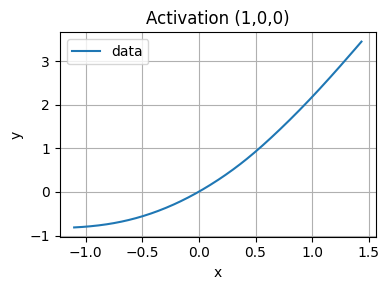

2025-03-31 16:01:34,080 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-31 16:01:34,081 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.6914739608764648, for constant: [0.77778005]
2025-03-31 16:01:34,081 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:01:39,393 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:01:39,394 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.00017301432671956718, params=[0.01770553 1.48592258 0.66595163], ansatz: params[0] + params[1] * x + params[2] * x**2...
2025-03-31 16:01:39,394 - LLMLEx.llmLEx - INFO - Exit condition met after initial population
2025-03-31 16:01:39,395 - LLMLEx.llmLEx - INFO - Successfully found expression for connection (1,0,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,0,0): params[0] * x**2 + params[1] * x + params[2], with score -0.00017301432671956718 and parameters [0.666 1.486 0.018]


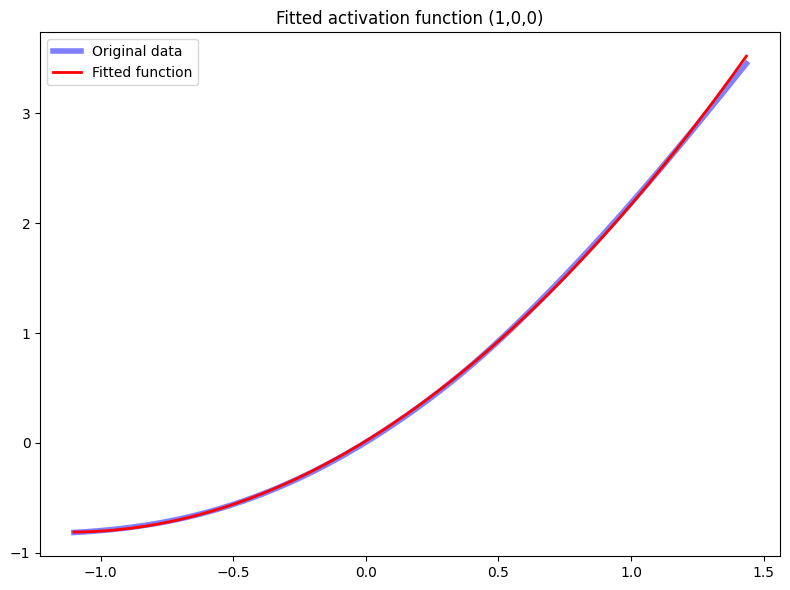

2025-03-31 16:01:39,492 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,1,0)


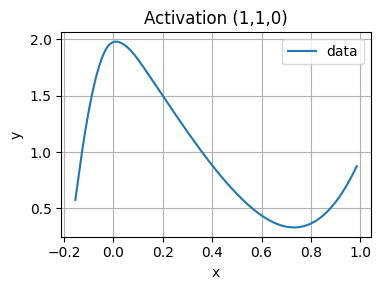

2025-03-31 16:01:39,560 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,1,0)
2025-03-31 16:01:39,562 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.2469030618667603, for constant: [1.30548833]
2025-03-31 16:01:39,562 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:01:49,038 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:01:49,039 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.02308313362300396, params=[-3.12993121e+05  2.00807576e-01  1.46183671e+00 -6.30198506e+03
  6.83745650e+03  3.11138941e+05], ansatz: params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4] * x + params[5]...
2025-03-31 16:01:49,039 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 16:01:50,353 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 16:02:01,5


API Call Statistics:
  Successful calls (end-to-end): 20
  Failed calls: 8
  Success rate: 71.43%

Breakdown by processing stage:
  Api Call: 28 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 26 succeeded, 2 failed (92.86% success)
  Function Conversion: 26 succeeded, 0 failed (100.00% success)
  Curve Fitting: 20 succeeded, 6 failed (76.92% success)

Error types:
  Extraction Errors:
    - llm refusal: 2
  Fitting Errors:
    - numerical error: 6
Approximation for (1,1,0): params[0] * np.sin(params[1] * x + params[2]) + params[3] * np.cos(params[4] * x + params[5]) + params[6] * x**2 + params[7] * x + params[8], with score -0.0008521986892446876 and parameters [ 81.829   4.888   2.1    75.042   5.013   3.607 -32.792  34.326  -1.62 ]


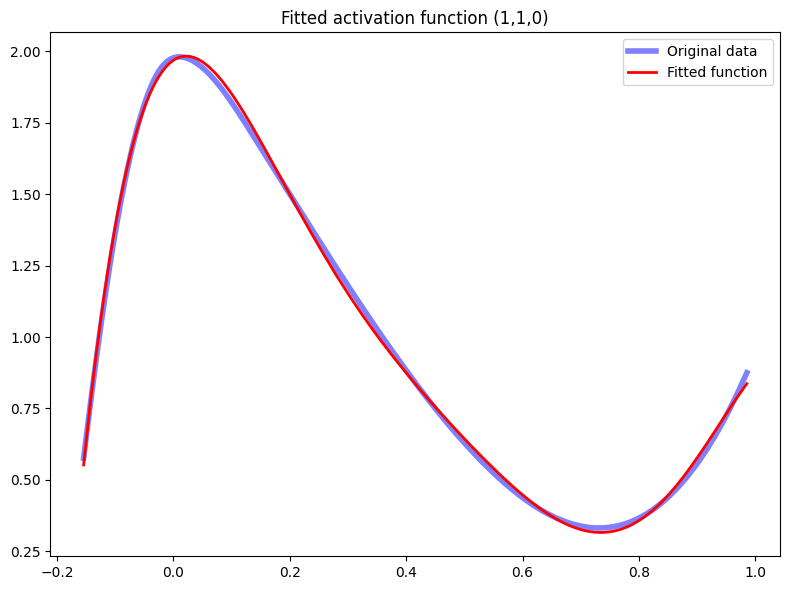

2025-03-31 16:02:42,188 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,2,0)


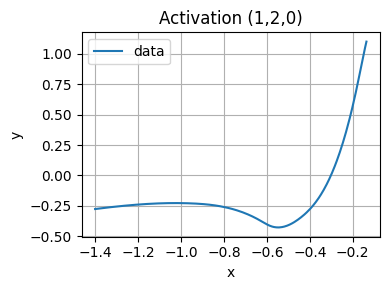

2025-03-31 16:02:42,257 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,2,0)
2025-03-31 16:02:42,259 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -11.10163688659668, for constant: [0.00014621]
2025-03-31 16:02:42,259 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:02:44,864 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 16:03:06,652 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:03:06,652 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.01841719262301922, params=[ 6.16719286  4.26684349 -1.92397523 -4.511792   -2.89322605], ansatz: params[0] * np.exp(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...
2025-03-31 16:03:06,653 - LLMLEx.llmLEx - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-31 16:03:07,972 - LLMLEx.llmLEx - WARNING - Ansatz extraction f


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 18
  Success rate: 68.97%

Breakdown by processing stage:
  Api Call: 58 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 45 succeeded, 13 failed (77.59% success)
  Function Conversion: 45 succeeded, 0 failed (100.00% success)
  Curve Fitting: 40 succeeded, 5 failed (88.89% success)

Error types:
  Extraction Errors:
    - no parameters: 5
    - llm refusal: 8
  Fitting Errors:
    - numerical error: 5

Validation issues:
  - nan values: 2

Fitting warnings:
  - covariance estimation: 2
  - invalid log: 16
Approximation for (1,2,0): params[0] * np.exp(params[1] * x) + params[2] * np.sin(params[3] * x) + params[4] * x**3 + params[5] * x**2 + params[6] * x + params[7], with score -0.0029863896779716015 and parameters [ 0.47  14.368  0.195  6.205  4.428 12.707 10.978  2.462]


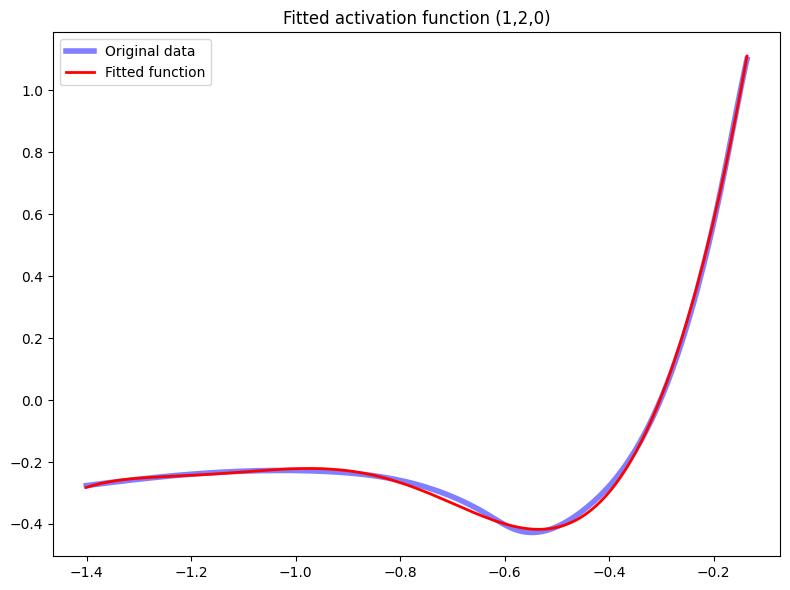

2025-03-31 16:04:20,770 - LLMLEx.llmLEx - INFO - KAN conversion complete: 6 total connections
2025-03-31 16:04:20,770 - LLMLEx.llmLEx - INFO - Connection breakdown: 0 symbolic, 0 zero, 6 processed
2025-03-31 16:04:20,883 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.60335305
2025-03-31 16:04:20,884 - LLMLEx.llmLEx - INFO - API key usage whilst this kan_to_symbolic was running: $0.30
2025-03-31 16:04:20,884 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * np.sin(params[5] * x**2) + params[6] * np.cos(params[7] * x**2) + params[8] * x**3 + params[9] * x**2 + params[10] * x + params[11], has parameters [ 0.7  2.   0.   3.1 -0.2  0.6 -0.   1.7 -0.   0.2  0.3 -0.2]
2025-03-31 16:04:20,885 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 1): params[0] * x**3 + params[1] * x**2 + params[2] * x + params[3] + params[4] * np.sin(params[5] * x) + params[6] * np.exp(params[7] * x), 

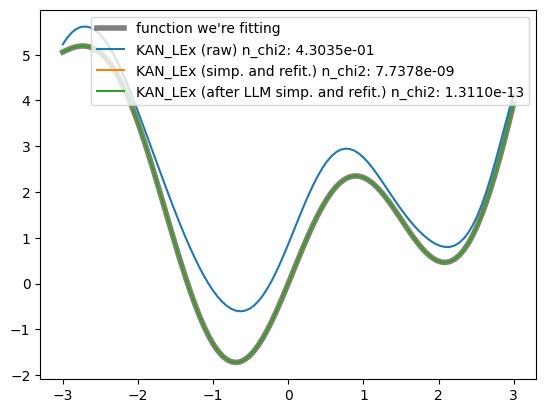

2025-03-31 16:10:33,431 - LLMLEx.kanLEx - INFO - 
###############################
# Raw and Refitted Results for output 0 (4sf): #
###############################
2025-03-31 16:10:33,432 - LLMLEx.kanLEx - INFO - Raw expression n_chi2 4.304e-01: 1.85*x0**3 + 14.14*x0**2 + 49.36*x0 + 0.5712*(-0.05508*x0**2 - 0.3558*x0 - 0.2548*sin(1.797*x0 - 3.865) + 0.07023*cos(2.798*x0 - 2.642) - 1)**3 + 3.244*(-0.05508*x0**2 - 0.3558*x0 - 0.2548*sin(1.797*x0 - 3.865) + 0.07023*cos(2.798*x0 - 2.642) - 1)**2 - 313.7*(0.01783*x0**3 + 0.1339*x0**2 + 0.4787*x0 - exp(0.4431*x0) + 0.008182*sin(2.261*x0) + 0.9686)**2 + 0.287*(-0.04434*x0**3 + 0.2354*x0**2 + 0.515*x0 + sin(2.046*x0) - 0.2713*sin(0.5945*x0**2) + 0.06037*cos(3.097*x0) - 0.005948*cos(1.747*x0**2) - 0.2609)**2 - 106.2*exp(0.4431*x0) + 0.0003307*exp(-0.3998*x0**2 - 2.583*x0 - 1.85*sin(1.797*x0 - 3.865) + 0.5099*cos(2.798*x0 - 2.642)) + 0.9755*sin(2.046*x0) + 0.8687*sin(2.261*x0) - 0.2646*sin(0.5945*x0**2) - 1.413*sin(1.797*x0 - 3.865) - 0.1945*sin(

In [16]:
# Run the complete pipeline
results = kansr2.run_complete_pipeline(
    client=client,
    f=target_function_2,
    ranges=(-3, 3),
    train_steps=500,
    generations=4,
    gpt_model="openai/gpt-4o",
    node_th=0.2,
    edge_th=0.2,
    optimiser="LBFGS",
    population=10,
    temperature=0.1,
    verbose=1,
    use_async=True,
    plot_fit=True
)

In [17]:
# Print the best expression from the pipeline
print(f"Best expression from pipeline: {results['best_expressions'][0]}")
print(f"Chi-squared: {results['best_n_chi_squareds'][0]}")

Best expression from pipeline: 2.19201369780912*x0**3 + 15.0651168566195*x0**2 + 37.1433506997442*x0 - 4.63638978508e-5*(np.sin(2.03064960258558*x0) - 0.596534596110657)**2 - 171.055791481633*(0.0132779712831092*x0**3 + 0.0875155151513163*x0**2 + 0.216491974171298*x0 - 0.64487791970868*np.exp(0.434040522248772*x0) + 0.0010679893399324*np.sin(1.79227339648423*x0) + 1)**2 - 108.526258004376*np.exp(0.434040522248772*x0) + 1.07763548101615*np.sin(1.79227339648423*x0) + 1.26873696598144*np.sin(2.03064960258558*x0) - 0.0690957716309661*np.sin(0.390079167161724*x0**2) - 1.35071312555027*np.sin(1.4734539880026*x0 - 3.05179867796939) + 0.191883129573792*np.cos(1.72186674518352*x0) + 129.785403169445
Chi-squared: 1.310954925344554e-13


## Method 3: Using the standalone function

You can also use the standalone function `run_complete_pipeline` from the kansr module. Note you can also decide to use a different LLM for simplification.

2025-03-31 16:23:33,506 - LLMLEx.kanLEx - INFO - Training KAN model with LBFGS optimiser for 50 steps


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.26e-03 | test_loss: 1.27e-03 | reg: 1.48e+01 | : 100%|█| 50/50 [00:10<00:00,  4.79it


saving model version 0.1
Unpruned model. Pruning? True


2025-03-31 16:23:44,412 - LLMLEx.kanLEx - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-31 16:23:44,422 - LLMLEx.kanLEx - INFO - Pruned model:


saving model version 0.2


2025-03-31 16:23:44,888 - LLMLEx.kanLEx - INFO - Final train loss: 0.0012644767994061112
2025-03-31 16:23:44,889 - LLMLEx.kanLEx - INFO - Trained model:
2025-03-31 16:23:45,558 - LLMLEx.kanLEx - INFO - Pruned model:
2025-03-31 16:23:46,160 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.69799305
2025-03-31 16:23:46,161 - LLMLEx.kanLEx - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-31 16:23:46,161 - LLMLEx.kanLEx - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-31 16:23:46,244 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 175.69799305
2025-03-31 16:23:46,245 - LLMLEx.llmLEx - INFO - Processing KAN model connections
2025-03-31 16:23:46,246 - LLMLEx.llmLEx - INFO - Processing

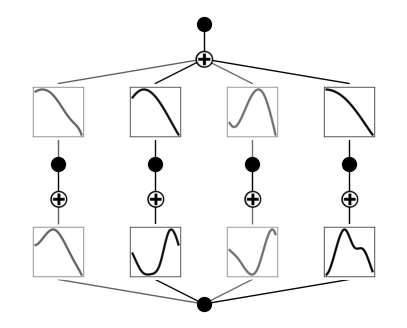

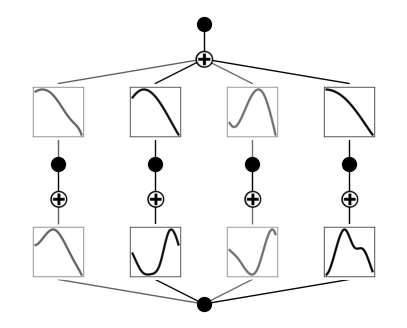

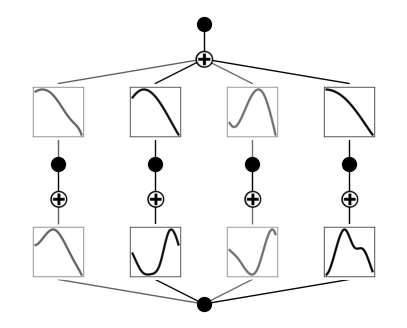

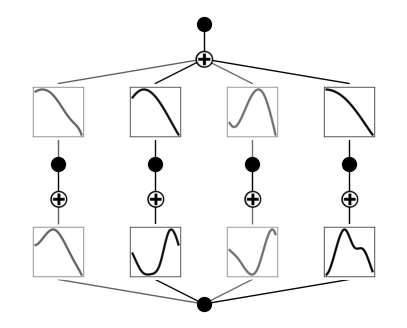

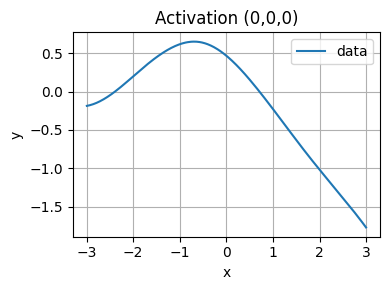

2025-03-31 16:23:46,971 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-31 16:23:46,973 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.9920780658721924, for constant: [-0.14464983]
2025-03-31 16:23:46,973 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:23:51,647 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:23:51,648 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.026838965713977814, params=[-0.70901175  0.57660938 -0.17238195  0.37185619], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3]...
2025-03-31 16:23:51,649 - LLMLEx.llmLEx - INFO - Generation 1/2: Generating 10 new individuals. Elitism? False
2025-03-31 16:23:54,148 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't help with that.'
2025-03-31 16:23:56,352 - LLMLEx.llmLEx - INFO - Generation 1 best: score=-0.003802604041993618, p


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 4
  Success rate: 88.24%

Breakdown by processing stage:
  Api Call: 34 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 4 failed (88.24% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - no parameters: 1
    - llm refusal: 3
Approximation for (0,0,0): params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**2 + params[5] * x + params[6], with score -1.8971497411257587e-05 and parameters [ 0.122 -1.572  0.273  1.18  -0.103 -0.303  0.193]


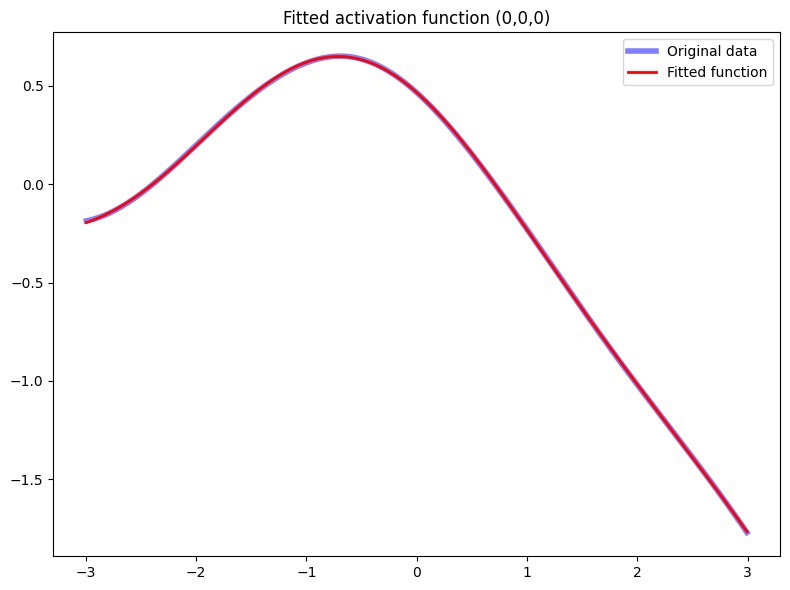

2025-03-31 16:24:01,489 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,1)


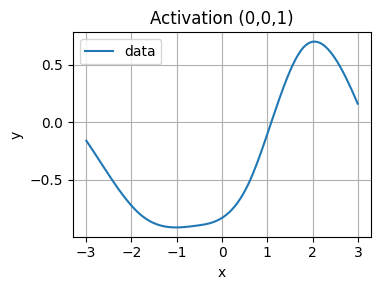

2025-03-31 16:24:01,557 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,1)
2025-03-31 16:24:01,558 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -2.0627214908599854, for constant: [-0.30288281]
2025-03-31 16:24:01,559 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:24:04,400 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:24:04,402 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.039611224085092545, params=[ 0.62584129  0.88448055 -0.44926047  1.27599203 -0.37841979], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4]...
2025-03-31 16:24:04,404 - LLMLEx.llmLEx - INFO - Generation 1/2: Generating 10 new individuals. Elitism? False
2025-03-31 16:24:05,474 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 16:24:05,623 - LLMLEx.llmLEx - WARNING - Ansatz extracti


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 9
  Success rate: 76.92%

Breakdown by processing stage:
  Api Call: 39 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 34 succeeded, 5 failed (87.18% success)
  Function Conversion: 34 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 4 failed (88.24% success)

Error types:
  Extraction Errors:
    - llm refusal: 5
  Fitting Errors:
    - numerical error: 4
Approximation for (0,0,1): params[0] * np.sin(params[1] * x + params[2]) + params[3] * np.cos(params[4] * x + params[5]) + params[6] * x**3, with score -0.008701838552951813 and parameters [-0.27   1.697 -5.312 -1.255  0.589  1.049 -0.043]


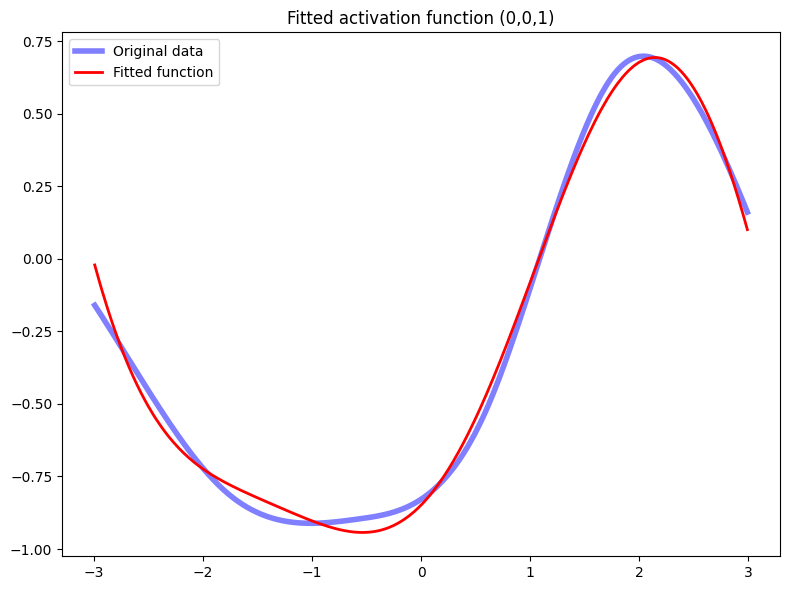

2025-03-31 16:24:30,921 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,2)


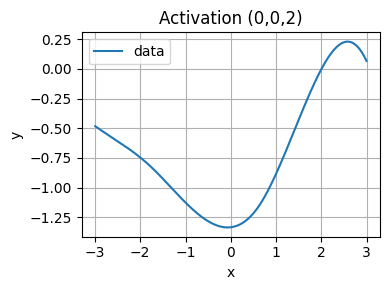

2025-03-31 16:24:30,991 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,2)
2025-03-31 16:24:30,992 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.822348952293396, for constant: [-0.70028931]
2025-03-31 16:24:30,992 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:24:35,468 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:24:35,469 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.016546059399843216, params=[ 0.45173607  0.39540563 -0.58593819  1.14280668 -0.75507163], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4]...
2025-03-31 16:24:35,471 - LLMLEx.llmLEx - INFO - Generation 1/2: Generating 10 new individuals. Elitism? False
2025-03-31 16:24:43,155 - LLMLEx.llmLEx - INFO - Generation 1 best: score=-0.014185032807290554, params=[ 1.22104922  0.52376969 -1.26277281  0.20724596  1.71884415  9.17357266], ansatz: params[0] * np.sin(params[1] 


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 3
  Success rate: 90.91%

Breakdown by processing stage:
  Api Call: 33 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 3 failed (90.91% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - llm refusal: 3
Approximation for (0,0,2): params[0] * np.cos(params[1] * x + params[2]) + params[3] * np.sin(params[4] * x) + params[5] * x + params[6], with score -0.0001520061632618308 and parameters [-8.52713e+02  1.14100e+00 -1.57000e+00  8.53074e+02  1.14100e+00
 -1.08000e-01 -7.56000e-01]


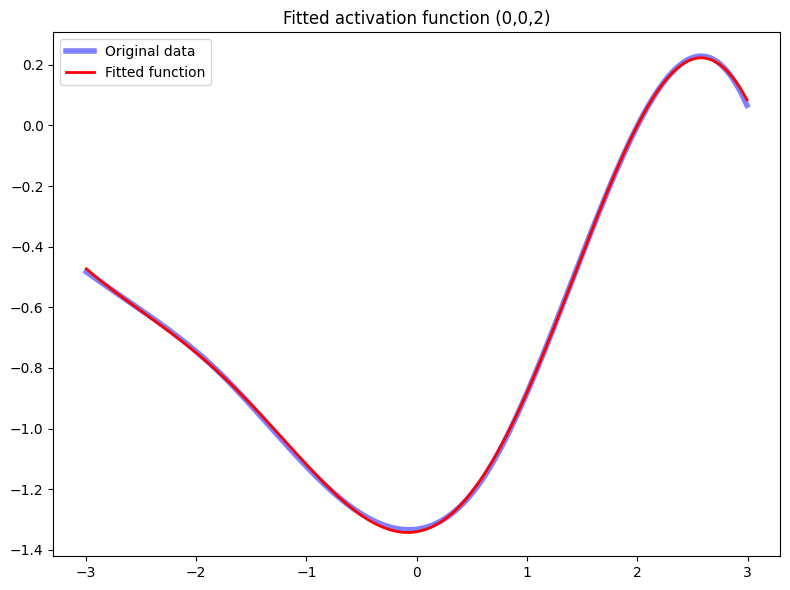

2025-03-31 16:24:56,787 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,3)


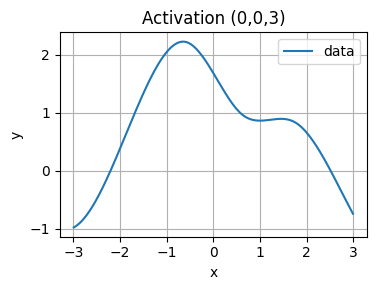

2025-03-31 16:24:56,852 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,3)
2025-03-31 16:24:56,854 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.7102301120758057, for constant: [0.80335371]
2025-03-31 16:24:56,854 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:25:02,921 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:25:02,922 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.005113507620990276, params=[-0.42870138  2.21481198  0.0475448  -0.30494855 -0.31695313  1.73340968], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4] * x + params[5]...
2025-03-31 16:25:02,923 - LLMLEx.llmLEx - INFO - Generation 1/2: Generating 10 new individuals. Elitism? False
2025-03-31 16:25:04,346 - LLMLEx.llmLEx - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-03-31 16:25:04,441 - LLMLEx.llmLE


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 9
  Success rate: 76.92%

Breakdown by processing stage:
  Api Call: 39 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 9 failed (76.92% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - llm refusal: 9
Approximation for (0,0,3): params[0] * np.sin(params[1] * x) + params[2] * np.exp(-params[3] * x**2) + params[4] * x**3 + params[5] * x**2 + params[6] * x + params[7], with score -0.0037219508085399866 and parameters [-0.428  2.22  -0.112  1.787  0.048 -0.314 -0.318  1.786]


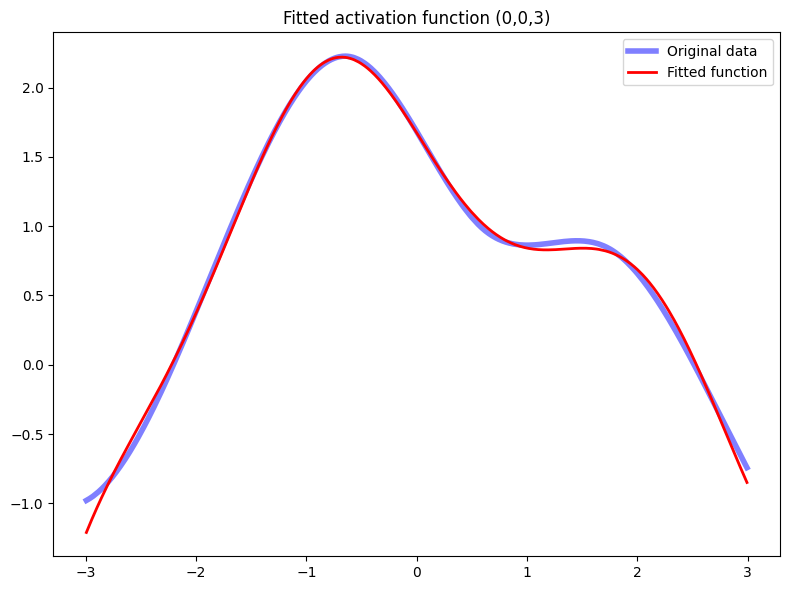

2025-03-31 16:25:16,089 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,0,0)


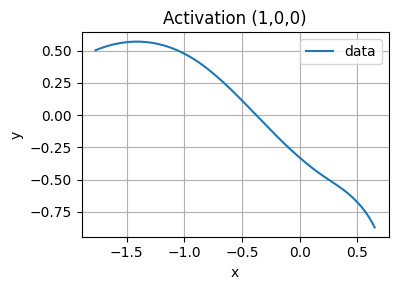

2025-03-31 16:25:16,154 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-31 16:25:16,155 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.8978278636932373, for constant: [-0.23331437]
2025-03-31 16:25:16,156 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:25:19,340 - LLMLEx.fit - INFO - All methods failed for this fit <function <lambda> at 0x38f49b7e0> Optimal parameters not found: Number of calls to function has reached maxfev = 4000.
2025-03-31 16:25:21,174 - LLMLEx.fit - INFO - All methods failed for this fit <function <lambda> at 0x38f49b600> Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
2025-03-31 16:25:22,439 - LLMLEx.fit - INFO - All methods failed for this fit <function <lambda> at 0x38f616660> Optimal parameters not found: Number of calls to function has reached maxfev = 4000.
2025-03-31 16:25:23,697 - LLMLEx.fit - INFO - All methods failed for thi


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 18
  Success rate: 62.50%

Breakdown by processing stage:
  Api Call: 48 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 46 succeeded, 2 failed (95.83% success)
  Function Conversion: 46 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 16 failed (65.22% success)

Error types:
  Extraction Errors:
    - llm refusal: 2
  Fitting Errors:
    - numerical error: 16

Fitting warnings:
  - covariance estimation: 1
  - invalid log: 8
Approximation for (1,0,0): params[0] * np.cos(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4] * x + params[5], with score -0.0005875956267118454 and parameters [-0.305  2.603 -0.304 -0.777 -0.713 -0.018]


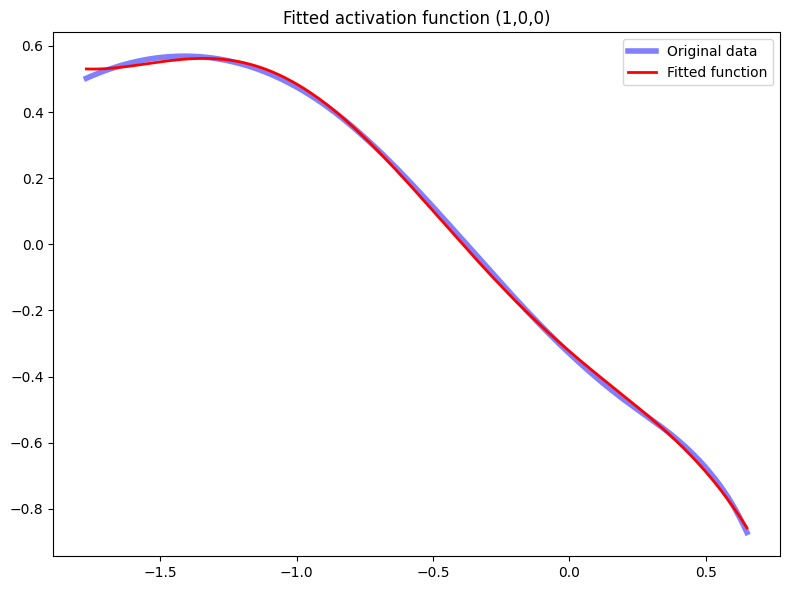

2025-03-31 16:26:00,443 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,1,0)


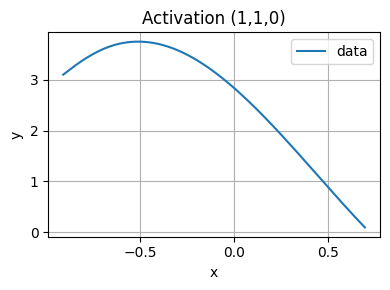

2025-03-31 16:26:00,503 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,1,0)
2025-03-31 16:26:00,505 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -7.948337078094482, for constant: [2.62483571]
2025-03-31 16:26:00,505 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:26:05,000 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:26:05,001 - LLMLEx.llmLEx - INFO - Initial population best: score=-9.304111154051498e-05, params=[ 0.60076111 -2.62208472 -2.03003701 -1.68753293  2.83509296], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...
2025-03-31 16:26:05,001 - LLMLEx.llmLEx - INFO - Exit condition met after initial population
2025-03-31 16:26:05,002 - LLMLEx.llmLEx - INFO - Successfully found expression for connection (1,1,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,1,0): params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4], with score -9.304111154051498e-05 and parameters [ 0.601 -2.622 -2.03  -1.688  2.835]


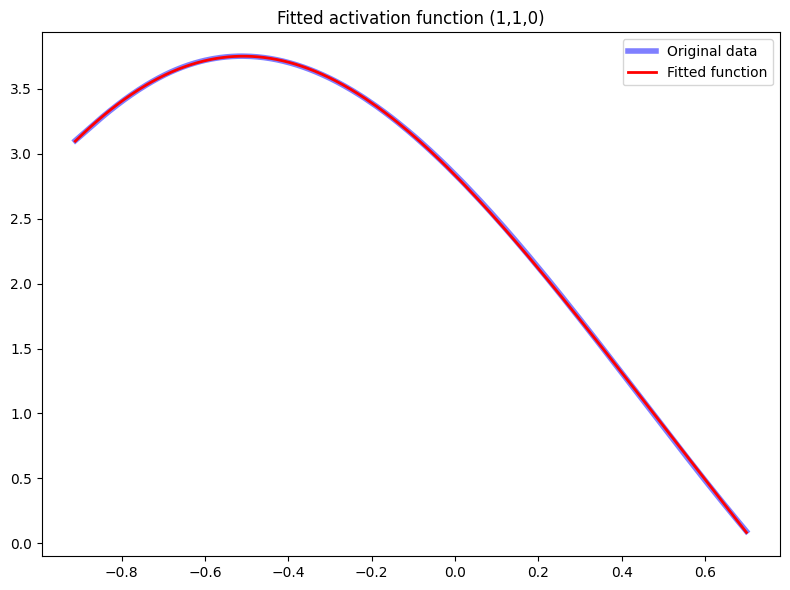

2025-03-31 16:26:05,103 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,2,0)


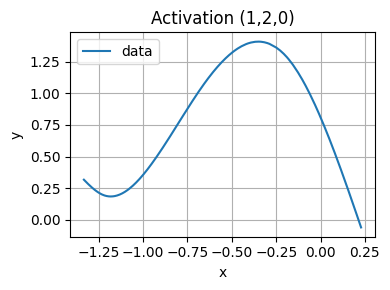

2025-03-31 16:26:05,172 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,2,0)
2025-03-31 16:26:05,173 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -4.123738765716553, for constant: [0.58882429]
2025-03-31 16:26:05,173 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:26:09,476 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:26:09,477 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.00044433047878555954, params=[ 2.80214481  2.21944536  2.10657264  2.26602796 -1.5954236 ], ansatz: params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4]...
2025-03-31 16:26:09,477 - LLMLEx.llmLEx - INFO - Exit condition met after initial population
2025-03-31 16:26:09,478 - LLMLEx.llmLEx - INFO - Successfully found expression for connection (1,2,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,2,0): params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4], with score -0.00044433047878555954 and parameters [ 2.802  2.219  2.107  2.266 -1.595]


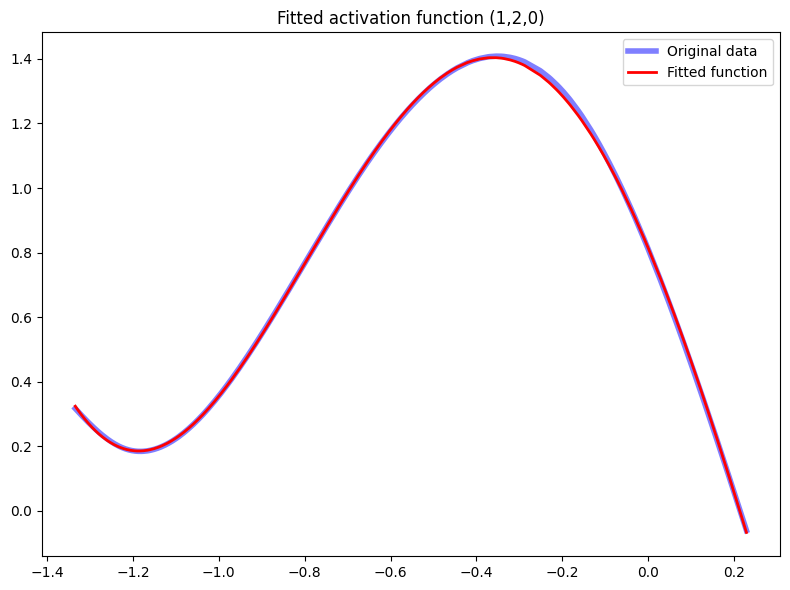

2025-03-31 16:26:09,579 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (1,3,0)


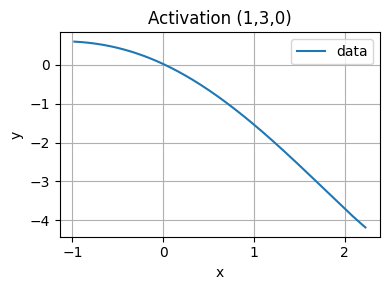

2025-03-31 16:26:09,639 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (1,3,0)
2025-03-31 16:26:09,641 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.5234302282333374, for constant: [-1.46225799]
2025-03-31 16:26:09,641 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:26:12,133 - LLMLEx.llmLEx - INFO - Generated 10 individuals
2025-03-31 16:26:12,133 - LLMLEx.llmLEx - INFO - Found 1 non-finite scores, setting all to -0.1291479915380478. Example ansatz: params[0] * np.log(params[1] + x) + params[2]
2025-03-31 16:26:12,133 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.0002820399822667241, params=[-11.0146422   -4.24187994   9.66724834   3.13112787], ansatz: params[0] + params[1]*x + params[2]*np.log(np.abs(x + params[3]))...
2025-03-31 16:26:12,133 - LLMLEx.llmLEx - INFO - Exit condition met after initial population
2025-03-31 16:26:12,134 - LLMLEx.llmLEx - INFO - Successfully found expression for


API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors

Validation issues:
  - nan values: 1

Fitting warnings:
  - covariance estimation: 1
  - invalid log: 24
Approximation for (1,3,0): params[0] + params[1]*x + params[2]*np.log(np.abs(x + params[3])), with score -0.0002820399822667241 and parameters [-11.015  -4.242   9.667   3.131]


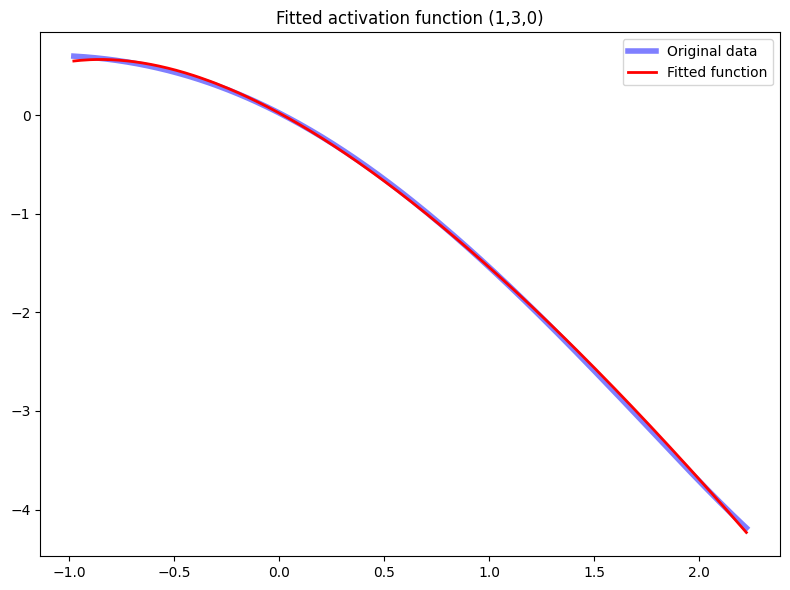

2025-03-31 16:26:12,206 - LLMLEx.llmLEx - INFO - KAN conversion complete: 8 total connections
2025-03-31 16:26:12,206 - LLMLEx.llmLEx - INFO - Connection breakdown: 0 symbolic, 0 zero, 8 processed
2025-03-31 16:26:12,267 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 176.00187305
2025-03-31 16:26:12,267 - LLMLEx.llmLEx - INFO - API key usage whilst this kan_to_symbolic was running: $0.30
2025-03-31 16:26:12,268 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**2 + params[5] * x + params[6], has parameters [ 0.1 -1.6  0.3  1.2 -0.1 -0.3  0.2]
2025-03-31 16:26:12,268 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 1): params[0] * np.sin(params[1] * x + params[2]) + params[3] * np.cos(params[4] * x + params[5]) + params[6] * x**3, has parameters [-0.3  1.7 -5.3 -1.3  0.6  1.  -0. ]
2025-03-31 16:26:12,269 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 2): params[0] * np.co

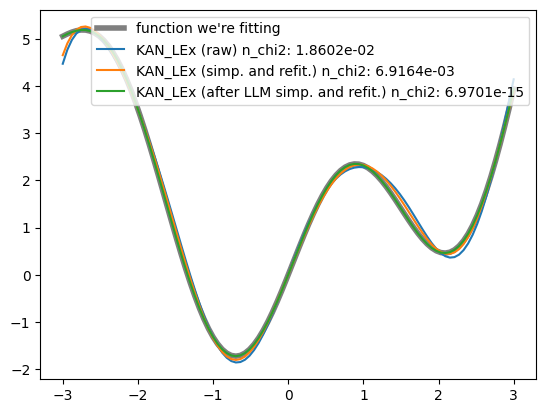

2025-03-31 16:34:19,242 - LLMLEx.kanLEx - INFO - 
###############################
# Raw and Refitted Results for output 0 (4sf): #
###############################
2025-03-31 16:34:19,242 - LLMLEx.kanLEx - INFO - Raw expression n_chi2 1.860e-02: -0.1308*x0**3 + 1.406*x0**2 + 1.566*x0 - 3.199*(-0.03413*x0**3 - 0.2152*sin(1.697*x0 - 5.312) - cos(0.5894*x0 + 1.049))**2 + 1.649e+06*(-0.0001268*x0 + sin(1.141*x0) - 0.9996*cos(1.141*x0 - 1.57) - 0.0008866)**2 - 0.008496*(-0.3391*x0**2 - x0 - 0.4032*sin(1.572*x0) + 0.9002*cos(1.18*x0) + 0.6368)**3 - 0.07147*(-0.3391*x0**2 - x0 - 0.4032*sin(1.572*x0) + 0.9002*cos(1.18*x0) + 0.6368)**2 + 9.667*log(Abs(-0.04788*x0**3 + 0.3142*x0**2 + 0.3182*x0 + 0.4276*sin(2.22*x0) - 4.917 + 0.1119*exp(-1.787*x0**2))) + 0.08725*sin(1.572*x0) + 1.814*sin(2.22*x0) + 0.4558*sin(1.697*x0 - 5.312) + 0.6008*sin(0.1124*x0**3 + 0.7083*sin(1.697*x0 - 5.312) + 3.292*cos(0.5894*x0 + 1.049)) - 2.802*sin(0.24*x0 - 1893*sin(1.141*x0) + 1893*cos(1.141*x0 - 1.57) - 0.4279) - 0.1

In [19]:
from LLM_LEx.kanLEx import run_complete_pipeline

# Run the complete pipeline using the standalone function
results_standalone = run_complete_pipeline(
    client=client,
    f=target_function_2,
    ranges=(-3, 3),
    width=[1, 4, 1],
    grid=5,
    k=3,
    train_steps=50,
    generations=3,
    gpt_model="openai/gpt-4o",
    device='cpu',
    node_th=0.2,
    edge_th=0.2,
    optimiser="LBFGS",
    population=10,
    temperature=0.1,
    verbose=1,
    use_async=True,
    plot_fit=True,
    seed=42,
    simplification_gpt_model='openai/o3-mini'
)

In [20]:
# Print the best expression from the standalone pipeline
print(f"Best expression from standalone pipeline: {results_standalone['best_expressions'][0]}")
print(f"Chi-squared: {results_standalone['best_n_chi_squareds'][0]}")

Best expression from standalone pipeline: -0.0015047286848912*x0**3*(0.013530260231859*x0 - 1)**3 - 0.0028134945896707*x0**3 - 0.0386328780717797*x0**2*(0.013530260231859*x0 - 1)**2 + 0.541254557143542*x0**2 + 0.0048946467904962*x0 + 2296863.48344421*(np.sin(1.13279047829231*x0) - np.cos(1.13279047829231*x0 - 1.57079635210266))**2 - 0.0002464040966917*(0.0443602875205036*np.sin(1.74066873351492*x0 - 5.2479204339558) + np.cos(0.678687324227851*x0 + 0.562362282926518))**2 + 1.99881381017893*np.sin(2.00009179095376*x0) + 0.0029735418673356*np.sin(1.74066873351492*x0 - 5.2479204339558) - 0.0028317547106621*np.cos(1.70613349661582*x0) + 0.0151568627607178*np.cos(0.678687324227851*x0 + 0.562362282926518) - 0.0123556216998714
Chi-squared: 6.970057093069661e-15


## Advanced Example: Multi-variate Function

The KANSR class can also handle multivariate functions.

In [21]:
# Define a multivariate function
def multivariate_function(x):
    """
    Function with two input variables: f(x0, x1) = sin(x0) + 0.5 * x1^2
    
    Args:
        x: Tensor of shape [n, 2] where n is batch size
        
    Returns:
        Tensor of shape [n] with function values
    """
    if isinstance(x, torch.Tensor):
        return torch.exp(torch.sin(torch.pi * x[:, 0]) + 0.5 * x[:, 1]**2)
    else:
        return np.exp(np.sin(np.pi * x[:, 0]) + 0.5 * x[:, 1]**2)

In [22]:
# Initialize a KANSR instance for the multivariate function
multivariate_kansr = KAN_LEx(
    client=client,
    width=[2, 1],  # 2 inputs, 5 hidden nodes, 1 output
    grid=5,
    k=3,
    seed=42
)

checkpoint directory created: ./model
saving model version 0.0


In [23]:
# Create a dataset for the multivariate function
multivariate_dataset = multivariate_kansr.create_dataset(
    f=multivariate_function,
    ranges=(-3, 3),  # Same range for both variables
    n_var=2,  # Two input variables
    train_num=10000,
    test_num=1000
)

2025-03-31 16:39:45,045 - LLMLEx.kanLEx - INFO - Training KAN model with LBFGS optimiser for 50 steps
| train_loss: 1.55e+01 | test_loss: 1.52e+01 | reg: 1.99e+01 | : 100%|█| 50/50 [00:01<00:00, 46.37it
2025-03-31 16:39:46,257 - LLMLEx.kanLEx - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-31 16:39:46,263 - LLMLEx.kanLEx - INFO - Pruned model:


saving model version 0.1
Unpruned model. Pruning? True
saving model version 0.2


2025-03-31 16:39:46,398 - LLMLEx.kanLEx - INFO - Final train loss: 15.525487899780273


15.525487899780273

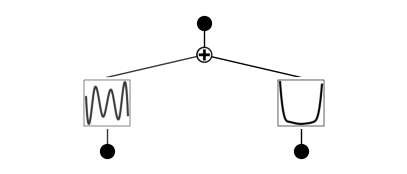

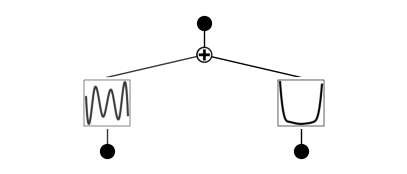

In [24]:
# Train the KAN model
multivariate_kansr.train_kan(
    dataset=multivariate_dataset,
    opt="LBFGS",
    steps=50,  # More steps for multivariate function
    prune=True,
    node_th=0.2,
    edge_th=0.2
)

2025-03-31 16:39:59,271 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 176.04640305
2025-03-31 16:39:59,272 - LLMLEx.kanLEx - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-31 16:39:59,272 - LLMLEx.kanLEx - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-31 16:39:59,337 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 176.04640305
2025-03-31 16:39:59,338 - LLMLEx.llmLEx - INFO - Processing KAN model connections
2025-03-31 16:39:59,339 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,0,0)


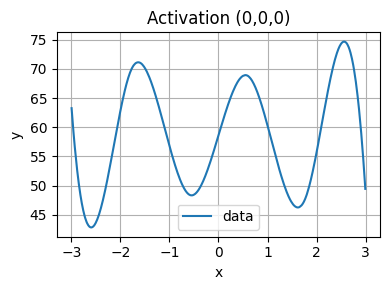

2025-03-31 16:39:59,430 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-31 16:39:59,433 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -1.1931297779083252, for constant: [58.53675286]
2025-03-31 16:39:59,434 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:40:02,843 - LLMLEx.llmLEx - INFO - Generated 3 individuals
2025-03-31 16:40:02,844 - LLMLEx.llmLEx - INFO - Initial population best: score=-0.06567708402872086, params=[ 58.55051647   0.46644698 -14.46272116   3.31371073  12.45381624
  -3.06635026  -4.75196188], ansatz: params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + param...


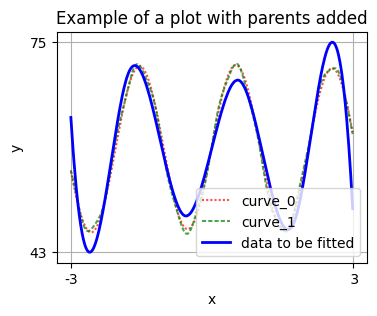

2025-03-31 16:40:02,916 - LLMLEx.llmLEx - INFO - Generation 1/1: Generating 3 new individuals. Elitism? False
2025-03-31 16:40:07,361 - LLMLEx.llmLEx - INFO - Generation 1 best: score=-1.0162625312805176, params=[58.72807954  3.29259337 -9.36522736  6.16292982  2.25010309 -6.92610579
 -1.99431711  7.78382722  4.03923019  5.62771999], ansatz: params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + param...
2025-03-31 16:40:07,362 - LLMLEx.llmLEx - INFO - Genetic algorithm completed after 2 generations
2025-03-31 16:40:07,362 - LLMLEx.llmLEx - INFO - Successfully found expression for connection (0,0,0)



API Call Statistics:
  Successful calls (end-to-end): 6
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 6 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 6 succeeded, 0 failed (100.00% success)
  Function Conversion: 6 succeeded, 0 failed (100.00% success)
  Curve Fitting: 6 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,0): params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + params[6]), with score -0.06567708402872086 and parameters [ 58.551   0.466 -14.463   3.314  12.454  -3.066  -4.752]


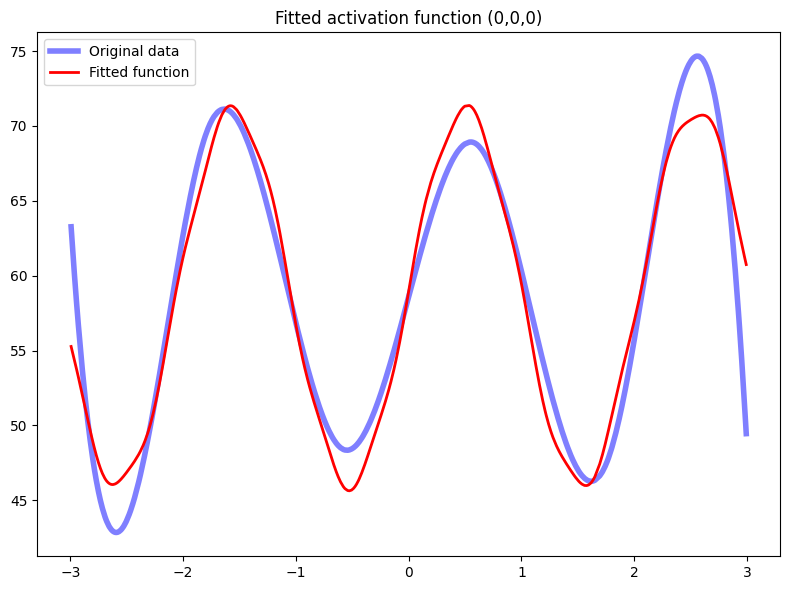

2025-03-31 16:40:07,453 - LLMLEx.llmLEx - INFO - Processing non-symbolic activation function (0,1,0)


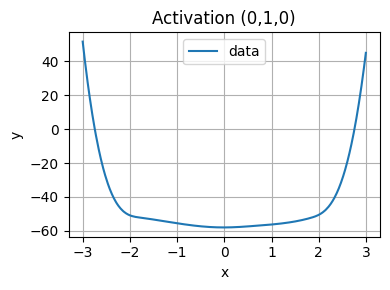

2025-03-31 16:40:07,524 - LLMLEx.llmLEx - INFO - Running genetic algorithm for connection (0,1,0)
2025-03-31 16:40:07,525 - LLMLEx.llmLEx - INFO - Constant function is not a good fit: Score: -47.40208053588867, for constant: [-42.77408483]
2025-03-31 16:40:07,526 - LLMLEx.llmLEx - INFO - Generating initial population asynchronously
2025-03-31 16:40:10,356 - LLMLEx.llmLEx - INFO - Generated 3 individuals
2025-03-31 16:40:10,357 - LLMLEx.llmLEx - INFO - Initial population best: score=-1.3752957582473755, params=[ 1.86430344e+00 -2.06495265e-02 -6.76717404e+00 -8.53936040e-02
 -5.33705646e+01], ansatz: params[0] * x**4 + params[1] * x**3 + params[2] * x**2 + params[3] * x + params[4]...


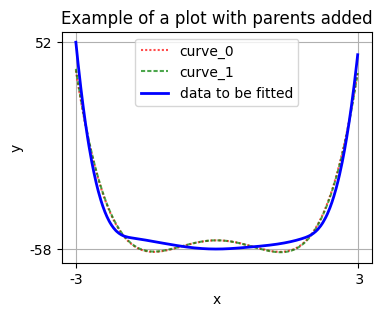

2025-03-31 16:40:10,438 - LLMLEx.llmLEx - INFO - Generation 1/1: Generating 3 new individuals. Elitism? False
2025-03-31 16:40:18,193 - LLMLEx.llmLEx - INFO - Generation 1 best: score=-1.3758727312088013, params=[-1.80322885e+01  1.10005108e-02  1.86441036e+00 -6.76878083e+00
 -5.33693787e+01], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**4 + params[3] * x**2 + params[4]...
2025-03-31 16:40:18,194 - LLMLEx.llmLEx - INFO - Genetic algorithm completed after 2 generations
2025-03-31 16:40:18,194 - LLMLEx.llmLEx - INFO - Successfully found expression for connection (0,1,0)



API Call Statistics:
  Successful calls (end-to-end): 6
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 6 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 6 succeeded, 0 failed (100.00% success)
  Function Conversion: 6 succeeded, 0 failed (100.00% success)
  Curve Fitting: 6 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,1,0): params[0] * x**4 + params[1] * x**3 + params[2] * x**2 + params[3] * x + params[4], with score -1.3752957582473755 and parameters [ 1.8640e+00 -2.1000e-02 -6.7670e+00 -8.5000e-02 -5.3371e+01]


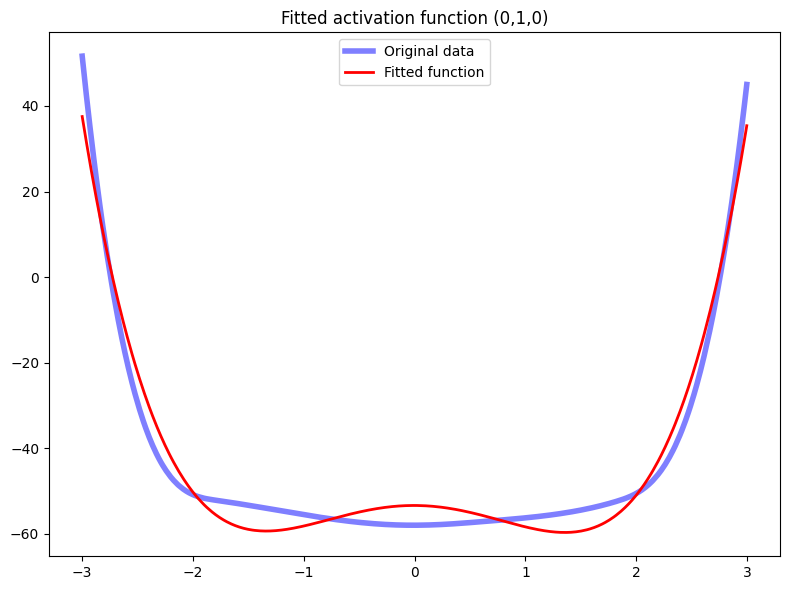

2025-03-31 16:40:18,284 - LLMLEx.llmLEx - INFO - KAN conversion complete: 2 total connections
2025-03-31 16:40:18,285 - LLMLEx.llmLEx - INFO - Connection breakdown: 0 symbolic, 0 zero, 2 processed
2025-03-31 16:40:18,417 - LLMLEx.llm - INFO - API key usage check successful. Current usage: 176.04640305
2025-03-31 16:40:18,417 - LLMLEx.llmLEx - INFO - API key usage whilst this kan_to_symbolic was running: $0.00
2025-03-31 16:40:18,418 - LLMLEx.kanLEx - INFO - Approximation for (0, 0, 0): params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + params[6]), has parameters [ 58.6   0.5 -14.5   3.3  12.5  -3.1  -4.8]
2025-03-31 16:40:18,419 - LLMLEx.kanLEx - INFO - Approximation for (0, 1, 0): params[0] * x**4 + params[1] * x**3 + params[2] * x**2 + params[3] * x + params[4], has parameters [  1.9  -0.   -6.8  -0.1 -53.4]
2025-03-31 16:40:18,419 - LLMLEx.kanLEx - INFO - Building expression tree
2025-03-31 16:40:18,419 - LLMLEx.kanLEx - INFO - KAN Connect

In [25]:
# Convert to symbolic expressions
best_expressions, best_chi_squareds, results_dicts, results_all_dicts = multivariate_kansr.get_symbolic(
    client=client,
    population=3,
    generations=2,
    temperature=0.1,
    gpt_model="openai/gpt-4o",
    verbose=1,
    use_async=True,
    plot_fit=True,
    plot_parents=True,
    demonstrate_parent_plotting=True
)

2025-03-31 16:40:32,861 - LLMLEx.kanLEx - INFO - Using internal dataset for plotting
2025-03-31 16:40:32,862 - LLMLEx.kanLEx - INFO - Using ranges derived from dataset: [(-2.9995217323303223, 2.999659538269043), (-2.9989681243896484, 2.999392509460449)]
2025-03-31 16:40:32,862 - LLMLEx.kanLEx - INFO - Plotting bivariate function
2025-03-31 16:40:32,869 - LLMLEx.kanLEx - INFO - Using self.f function for ground truth
2025-03-31 16:40:32,887 - LLMLEx.kanLEx - INFO - Argument x of learned function are arraylike, NOT x0, x1, etc.
2025-03-31 16:40:32,888 - LLMLEx.kanLEx - WARNING - SciPy optimisation failed: operands could not be broadcast together with shapes (50,50) (2500,) 
2025-03-31 16:40:32,902 - LLMLEx.kanLEx - WARNING - JAX optimisation failed: minimize() missing 1 required keyword-only argument: 'method'
2025-03-31 16:40:32,902 - LLMLEx.kanLEx - WARNING - Both optimisation methods failed, using original parameters
2025-03-31 16:40:32,903 - LLMLEx.kanLEx - WARNING - Python program ge

(10000,) (10000,) (10000,)


(<Figure size 1200x800 with 2 Axes>,
 <Axes3D: title={'center': 'KAN Symbolic Regression Results\nBest Expression (χ²=3.51293e+01)'}, xlabel='X0', ylabel='X1', zlabel='Y'>)

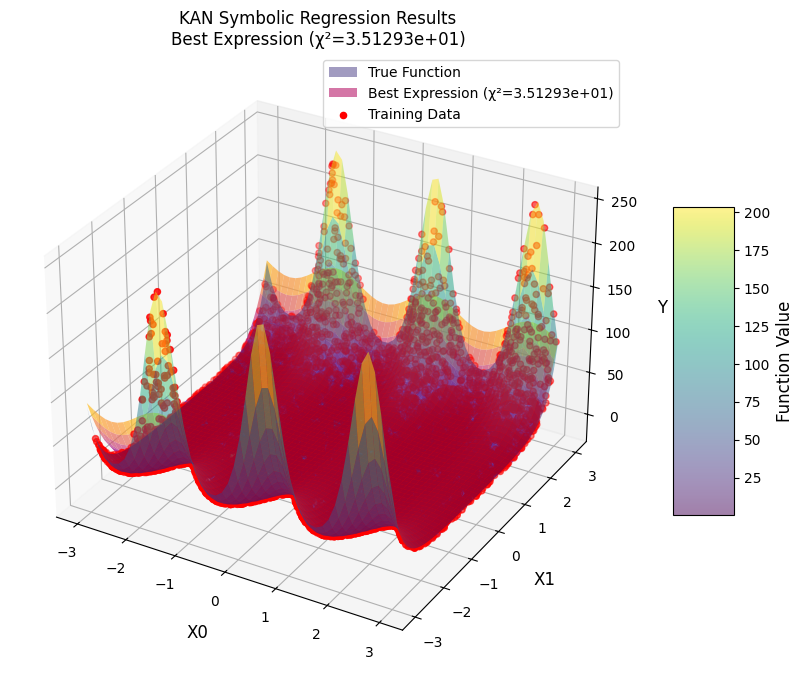

In [26]:
multivariate_kansr.plot_results()

Mean Squared Error with symbolic expression: 252.403702
Symbolic expression: 1.80235389011896*x1**4 - 0.0416760462549989*x1**3 - 6.33817584729961*x1**2 + 0.0313057423317889*x1 + 13.2188059864102*np.cos(3.14158742756296*x0 + 4.73737532980177) + 4.84068908971911


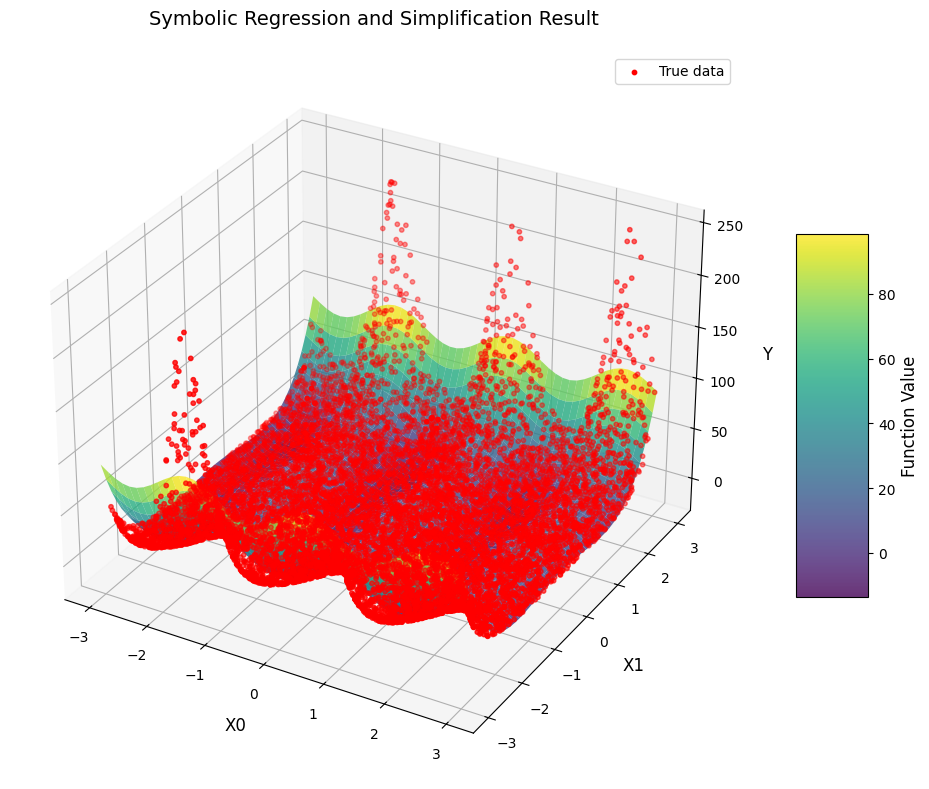

In [27]:
from LLM_LEx.images import plot_3d_function
dataset = multivariate_kansr.dataset
# Create a grid of input points
extractrange = 'train_input'
plot_type = 'train_input','train_label'
x0_range = np.linspace(min(dataset[plot_type[0]][:,0]), max(dataset[plot_type[0]][:,0]), 50)
x1_range = np.linspace(min(dataset[plot_type[0]][:,1]), max(dataset[plot_type[0]][:,1]), 50)
X0, X1 = np.meshgrid(x0_range, x1_range)

# Extract test data
test_x0 = dataset[plot_type[0]][:,0].cpu().detach().numpy()
test_x1 = dataset[plot_type[0]][:,1].cpu().detach().numpy()
test_y = dataset[plot_type[1]].cpu().detach().numpy().flatten()
test_data = (test_x0, test_x1, test_y)

# # Create figure with two subplots
# fig = plt.figure(figsize=(12, 8))
# ax1 = fig.add_subplot(121, projection='3d')
# ax2 = fig.add_subplot(122, projection='3d')



# Plot symbolic regression result if available
if best_expressions[0] is not None:
    # Create a symbolic function from the best expression
    symbolic_func = eval('lambda x0,x1:' + best_expressions[0])
    
    # Compute function values with symbolic expression
    Z_symbolic = np.zeros(X0.shape)
    for i in range(len(x0_range)):
        for j in range(len(x1_range)):
            try:
                Z_symbolic[j, i] = symbolic_func(X0[j, i], X1[j, i])
            except:
                Z_symbolic[j, i] = np.nan
    
    # Create new figure for symbolic result
    fig2 = plt.figure(figsize=(12, 8))
    ax3 = fig2.add_subplot(111, projection='3d')
    
    # Plot symbolic regression result
    plot_3d_function(x0_range, x1_range, Z_symbolic, test_data, 
                    'Symbolic Regression and Simplification Result', 'viridis', ax3)
    
    # Calculate MSE for symbolic expression
    y_pred_symbolic = np.array([symbolic_func(x0, x1) for x0, x1 in zip(test_x0, test_x1)])
    mse_symbolic = np.mean((y_pred_symbolic - test_y)**2)
    
    print(f"Mean Squared Error with symbolic expression: {mse_symbolic:.6f}")
    print(f"Symbolic expression: {best_expressions[0]}")

plt.tight_layout()
plt.show()


In [28]:
# Print the best expression
print(f"Best multivariate expression: {best_expressions[0]}")
print(f"Chi-squared: {best_chi_squareds[0]}")

Best multivariate expression: 1.80235389011896*x1**4 - 0.0416760462549989*x1**3 - 6.33817584729961*x1**2 + 0.0313057423317889*x1 + 13.2188059864102*np.cos(3.14158742756296*x0 + 4.73737532980177) + 4.84068908971911
Chi-squared: 35.129276275634766


# Here's some code explaining how the n_chi-squared works, and demonstrating what it's sensitive to:

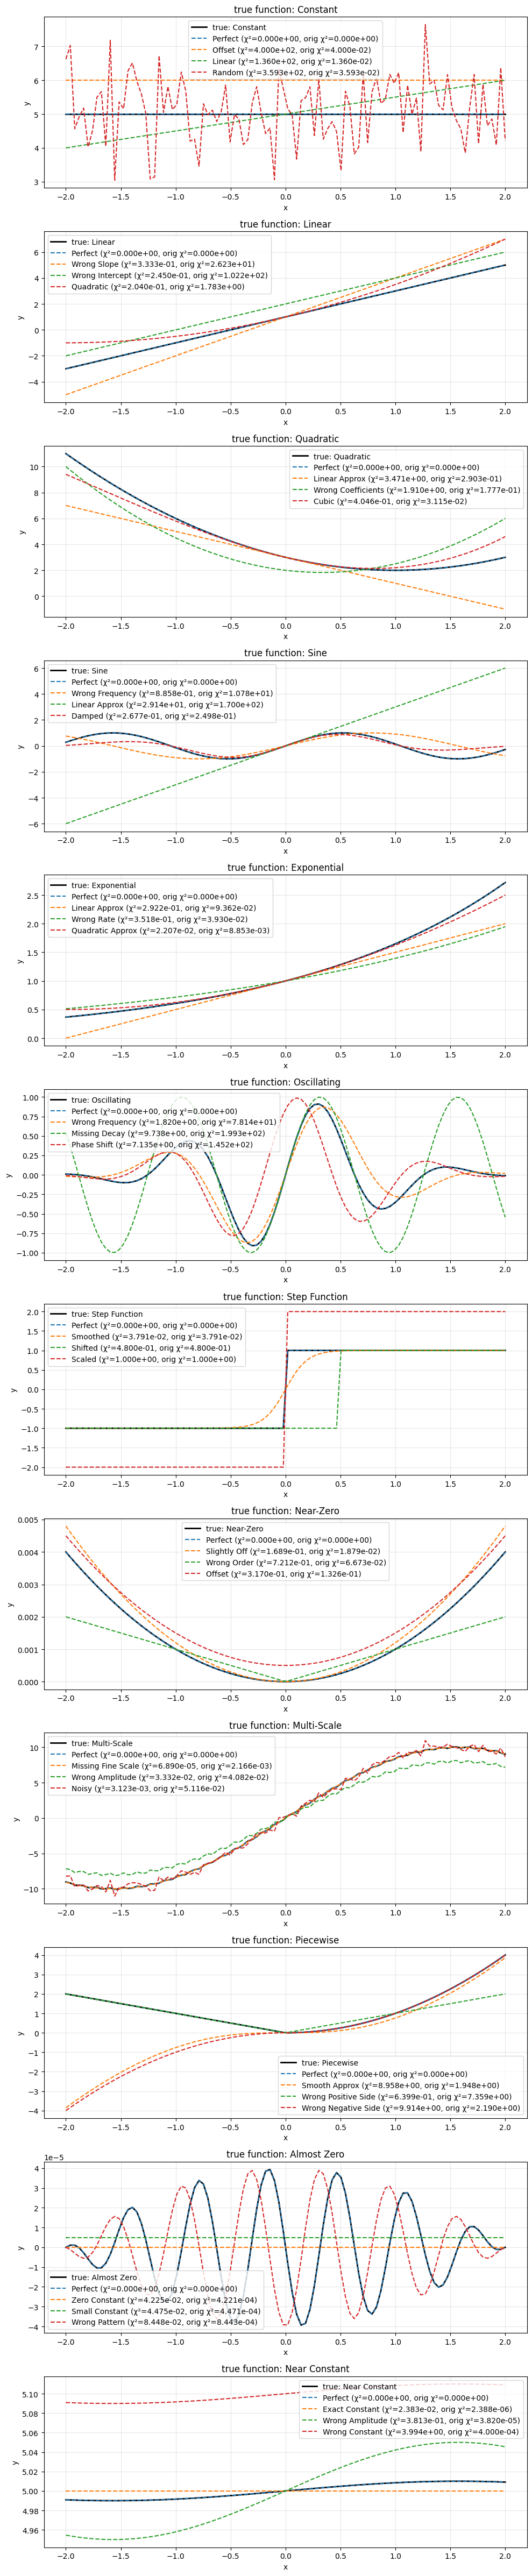

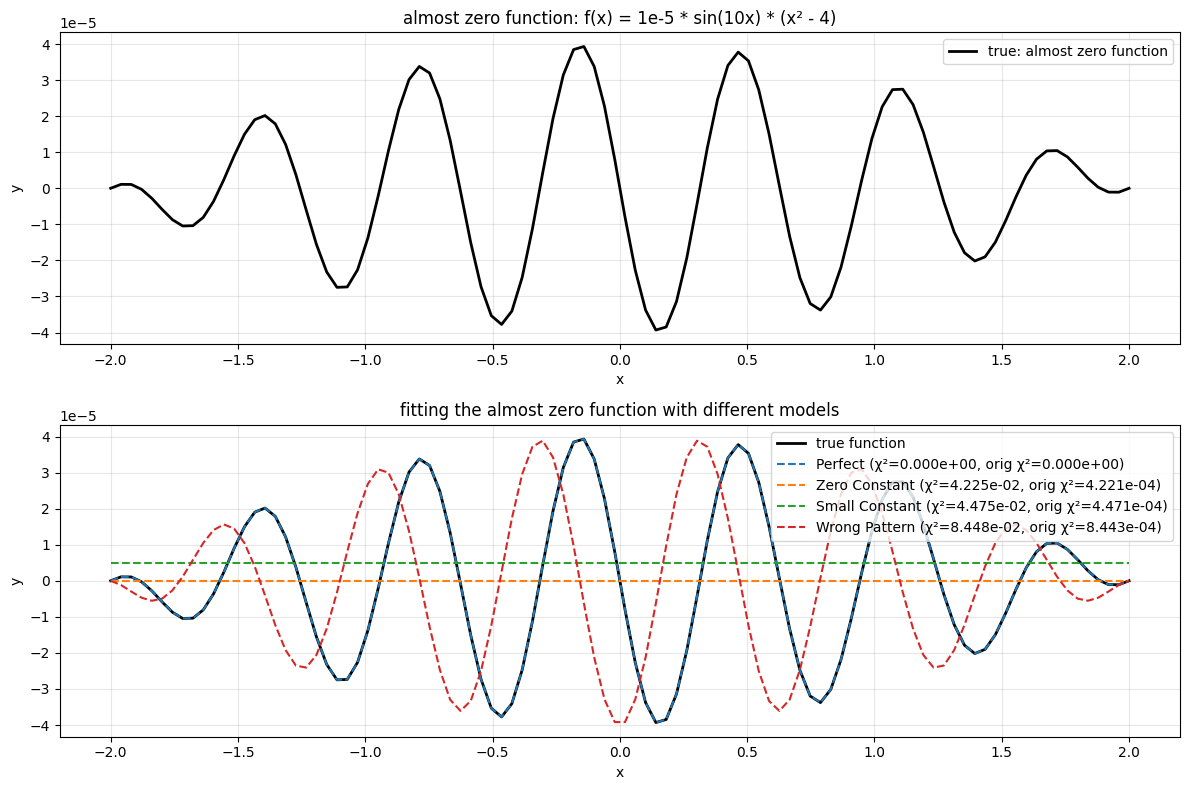

summary of normalized chi-squared values:
--------------------------------------------------------------------------------
true function   | prediction      | χ²         | orig χ²   
--------------------------------------------------------------------------------
Constant        | Perfect         | 0.000e+00  | 0.000e+00 
Constant        | Offset          | 4.000e+02  | 4.000e-02 
Constant        | Linear          | 1.360e+02  | 1.360e-02 
Constant        | Random          | 3.593e+02  | 3.593e-02 
Linear          | Perfect         | 0.000e+00  | 0.000e+00 
Linear          | Wrong Slope     | 3.333e-01  | 2.623e+01 
Linear          | Wrong Intercept | 2.450e-01  | 1.022e+02 
Linear          | Quadratic       | 2.040e-01  | 1.783e+00 
Quadratic       | Perfect         | 0.000e+00  | 0.000e+00 
Quadratic       | Linear Approx   | 3.471e+00  | 2.903e-01 
Quadratic       | Wrong Coefficients | 1.910e+00  | 1.777e-01 
Quadratic       | Cubic           | 4.046e-01  | 3.115e-02 
Sine         

In [30]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

def get_n_chi_squared_from_predictions(x, y, predictions, alpha=0.01, eps_scale=1e-4):
    """
    Calculate a robust, scale-invariant "normalized chi-squared" from actual values and predictions.

    Args:
        x: Input data points (not used, kept for API consistency)
        y: Actual target values (1D array)
        predictions: Predicted values (1D array)
        alpha: Small fraction for relative scale (default 0.01)
        eps_scale: Absolute floor to avoid zero in scale (default 1e-8)

    Returns:
        float: Robust normalized chi-squared value
    """
    # Residuals
    residuals = y - predictions

    # A simple scale measure: median absolute deviation
    median_y = jnp.median(y)
    mad_y = jnp.median(jnp.abs(y - median_y))

    # Mean of absolute y (for additional scale-based floor)
    mean_abs_y = jnp.mean(jnp.abs(y))

    # Define a robust global scale, ensuring it never collapses to zero
    # (ties scale to MAD and a fraction of the mean magnitude)
    global_scale = jnp.maximum(mad_y, alpha * mean_abs_y)
    global_scale = jnp.maximum(global_scale, eps_scale)

    # For each data point, define a local denominator to smoothly handle
    # relative vs. absolute error. This prevents blow-up near zero.
    # delta_i = max(global_scale, alpha * |y_i|)
    abs_y = jnp.abs(y)
    local_scale = jnp.maximum(global_scale, alpha * abs_y)

    # Compute normalized chi-squared
    # (residual^2 / local_scale^2), then average
    n_chi_squared = jnp.mean((residuals ** 2) / (local_scale ** 2))

    return n_chi_squared 

def get_original_chi_squared(y, predictions, eps_scale=1e-6):
    """
    Calculate the original chi-squared as mean(residuals^2)/mean(y^2)
    
    Args:
        y: Actual target values (1D array)
        predictions: Predicted values (1D array)
        
    Returns:
        float: Original chi-squared value
    """
    residuals = y - predictions
    return jnp.mean(residuals**2 /( y**2 + eps_scale))

# Test the function on various true functions and predictions
x = jnp.linspace(-2, 2, 100)  # Domain [-2, 2]

# Define several true functions
true_functions = {
    "Constant": lambda x: jnp.ones_like(x) * 5,
    "Linear": lambda x: 2*x + 1,
    "Quadratic": lambda x: x**2 - 2*x + 3,
    "Sine": lambda x: jnp.sin(3*x),
    "Exponential": lambda x: jnp.exp(x/2),
    # Additional challenging functions
    "Oscillating": lambda x: jnp.sin(5*x) * jnp.exp(-x**2),
    "Step Function": lambda x: jnp.where(x > 0, 1.0, -1.0),
    "Near-Zero": lambda x: 0.001 * x**2,
    "Multi-Scale": lambda x: 10*jnp.sin(x) + 0.1*jnp.sin(50*x),
    "Piecewise": lambda x: jnp.where(x > 0, x**2, -x),  # This is piecewise
    # New approximately zero function
    "Almost Zero": lambda x: 1e-5 * jnp.sin(10*x) * (x**2 - 4),
    # Near constant function at approximately 5
    "Near Constant": lambda x: 5 + 0.01 * jnp.sin(x)
}

# Create a random key for jax random operations
key = jr.PRNGKey(0)

# For each true function, define several predictions with varying accuracy
predictions = {
    "Constant": [
        ("Perfect", lambda x: jnp.ones_like(x) * 5),
        ("Offset", lambda x: jnp.ones_like(x) * 6),
        ("Linear", lambda x: 0.5*x + 5),
        ("Random", lambda x: jnp.ones_like(x) * 5 + jr.normal(key, shape=x.shape))
    ],
    "Linear": [
        ("Perfect", lambda x: 2*x + 1),
        ("Wrong Slope", lambda x: 3*x + 1),
        ("Wrong Intercept", lambda x: 2*x + 2),
        ("Quadratic", lambda x: 0.5*x**2 + 2*x + 1)
    ],
    "Quadratic": [
        ("Perfect", lambda x: x**2 - 2*x + 3),
        ("Linear Approx", lambda x: -2*x + 3),
        ("Wrong Coefficients", lambda x: 1.5*x**2 - x + 2),
        ("Cubic", lambda x: 0.2*x**3 + x**2 - 2*x + 3)
    ],
    "Sine": [
        ("Perfect", lambda x: jnp.sin(3*x)),
        ("Wrong Frequency", lambda x: jnp.sin(2*x)),
        ("Linear Approx", lambda x: 3*x),
        ("Damped", lambda x: jnp.sin(3*x) * jnp.exp(-0.5*x**2))
    ],
    "Exponential": [
        ("Perfect", lambda x: jnp.exp(x/2)),
        ("Linear Approx", lambda x: 1 + x/2),
        ("Wrong Rate", lambda x: jnp.exp(x/3)),
        ("Quadratic Approx", lambda x: 1 + x/2 + x**2/8)
    ],
    # Additional challenging cases
    "Oscillating": [
        ("Perfect", lambda x: jnp.sin(5*x) * jnp.exp(-x**2)),
        ("Wrong Frequency", lambda x: jnp.sin(4*x) * jnp.exp(-x**2)),
        ("Missing Decay", lambda x: jnp.sin(5*x)),
        ("Phase Shift", lambda x: jnp.sin(5*x + 1) * jnp.exp(-x**2))
    ],
    "Step Function": [
        ("Perfect", lambda x: jnp.where(x > 0, 1.0, -1.0)),
        ("Smoothed", lambda x: jnp.tanh(5*x)),
        ("Shifted", lambda x: jnp.where(x > 0.5, 1.0, -1.0)),
        ("Scaled", lambda x: jnp.where(x > 0, 2.0, -2.0))
    ],
    "Near-Zero": [
        ("Perfect", lambda x: 0.001 * x**2),
        ("Slightly Off", lambda x: 0.0012 * x**2),
        ("Wrong Order", lambda x: 0.001 * jnp.abs(x)),
        ("Offset", lambda x: 0.001 * x**2 + 0.0005)
    ],
    "Multi-Scale": [
        ("Perfect", lambda x: 10*jnp.sin(x) + 0.1*jnp.sin(50*x)),
        ("Missing Fine Scale", lambda x: 10*jnp.sin(x)),
        ("Wrong Amplitude", lambda x: 8*jnp.sin(x) + 0.2*jnp.sin(50*x)),
        ("Noisy", lambda x: 10*jnp.sin(x) + 0.1*jnp.sin(50*x) + 0.5*jr.normal(key, shape=x.shape))
    ],
    "Piecewise": [
        ("Perfect", lambda x: jnp.where(x > 0, x**2, -x)),
        ("Smooth Approx", lambda x: x**2 * jnp.tanh(x)),
        ("Wrong Positive Side", lambda x: jnp.where(x > 0, x, -x)),
        ("Wrong Negative Side", lambda x: jnp.where(x > 0, x**2, -x**2))
    ],
    # New predictions for the almost zero function
    "Almost Zero": [
        ("Perfect", lambda x: 1e-5 * jnp.sin(10*x) * (x**2 - 4)),
        ("Zero Constant", lambda x: jnp.zeros_like(x)),  # Constant zero
        ("Small Constant", lambda x: jnp.ones_like(x) * 5e-6),  # Small non-zero constant
        ("Wrong Pattern", lambda x: 1e-5 * jnp.cos(10*x) * (x**2 - 4))  # Wrong oscillation pattern
    ],
    # Predictions for the near constant function
    "Near Constant": [
        ("Perfect", lambda x: 5 + 0.01 * jnp.sin(x)),
        ("Exact Constant", lambda x: jnp.ones_like(x) * 5),  # Pure constant approximation
        ("Wrong Amplitude", lambda x: 5 + 0.05 * jnp.sin(x)),  # Larger oscillation
        ("Wrong Constant", lambda x: 5.1 + 0.01 * jnp.sin(x))  # Offset baseline
    ]
}

# Create plots for each true function
fig, axes = plt.subplots(len(true_functions), 1, figsize=(10, 4*len(true_functions)))

for i, (func_name, true_func) in enumerate(true_functions.items()):
    ax = axes[i]
    
    # Calculate true values
    y_true = true_func(x)
    
    # Plot true function
    ax.plot(x, y_true, 'k-', linewidth=2, label=f'true: {func_name}')
    
    # Plot and evaluate each prediction
    for pred_name, pred_func in predictions[func_name]:
        y_pred = pred_func(x)
        chi2 = get_n_chi_squared_from_predictions(x, y_true, y_pred)
        orig_chi2 = get_original_chi_squared(y_true, y_pred)
        ax.plot(x, y_pred, '--', linewidth=1.5, label=f'{pred_name} (χ²={chi2:.3e}, orig χ²={orig_chi2:.3e})')
    
    ax.set_title(f'true function: {func_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Special focus on the "Almost Zero" function
plt.figure(figsize=(12, 8))

# Get the true function and its predictions
almost_zero_func = true_functions["Almost Zero"]
y_true = almost_zero_func(x)

plt.subplot(2, 1, 1)
plt.plot(x, y_true, 'k-', linewidth=2, label='true: almost zero function')
plt.title('almost zero function: f(x) = 1e-5 * sin(10x) * (x² - 4)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, y_true, 'k-', linewidth=2, label='true function')

# Plot each prediction with chi-squared value
for pred_name, pred_func in predictions["Almost Zero"]:
    y_pred = pred_func(x)
    chi2 = get_n_chi_squared_from_predictions(x, y_true, y_pred)
    orig_chi2 = get_original_chi_squared(y_true, y_pred)
    plt.plot(x, y_pred, '--', linewidth=1.5, label=f'{pred_name} (χ²={chi2:.3e}, orig χ²={orig_chi2:.3e})')

plt.title('fitting the almost zero function with different models')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print a summary table of chi-squared values
print("summary of normalized chi-squared values:")
print("-" * 80)
print(f"{'true function':<15} | {'prediction':<15} | {'χ²':<10} | {'orig χ²':<10}")
print("-" * 80)

for func_name, true_func in true_functions.items():
    y_true = true_func(x)
    for pred_name, pred_func in predictions[func_name]:
        y_pred = pred_func(x)
        chi2 = get_n_chi_squared_from_predictions(x, y_true, y_pred)
        orig_chi2 = get_original_chi_squared(y_true, y_pred)
        print(f"{func_name:<15} | {pred_name:<15} | {chi2:<10.3e} | {orig_chi2:<10.3e}")

# Demonstrate why this measure is superior to traditional metrics
print("\nwhy this normalized chi-squared measure is superior:")
print("-" * 60)

# Case 1: Compare with traditional MSE for different scales
print("1. scale invariance:")
large_scale_func = lambda x: 1000 * jnp.sin(x)
small_scale_func = lambda x: 0.001 * jnp.sin(x)

large_pred = lambda x: 1000 * jnp.sin(x) * 0.9  # 10% off
small_pred = lambda x: 0.001 * jnp.sin(x) * 0.9  # 10% off

large_y = large_scale_func(x)
small_y = small_scale_func(x)
large_pred_y = large_pred(x)
small_pred_y = small_pred(x)

large_mse = jnp.mean((large_y - large_pred_y)**2)
small_mse = jnp.mean((small_y - small_pred_y)**2)
large_chi2 = get_n_chi_squared_from_predictions(x, large_y, large_pred_y)
small_chi2 = get_n_chi_squared_from_predictions(x, small_y, small_pred_y)
large_orig_chi2 = get_original_chi_squared(large_y, large_pred_y)
small_orig_chi2 = get_original_chi_squared(small_y, small_pred_y)

print(f"large scale function mse: {large_mse:.3e}, chi²: {large_chi2:.3e}, orig χ²: {large_orig_chi2:.3e}")
print(f"small scale function mse: {small_mse:.3e}, chi²: {small_chi2:.3e}, orig χ²: {small_orig_chi2:.3e}")
print(f"mse ratio: {large_mse/small_mse:.3e}, chi² ratio: {large_chi2/small_chi2:.3e}, orig χ² ratio: {large_orig_chi2/small_orig_chi2:.3e}")
print("→ our measure correctly identifies that both predictions have similar quality (10% off),")
print("  while mse is dominated by the function's scale.")

# Case 2: Handling near-zero values
print("\n2. robustness near zero:")
zero_cross_func = lambda x: x
zero_cross_pred1 = lambda x: x + 0.1  # constant offset
zero_cross_pred2 = lambda x: 1.1 * x  # proportional error

zero_y = zero_cross_func(x)
zero_pred1_y = zero_cross_pred1(x)
zero_pred2_y = zero_cross_pred2(x)

# Calculate relative error at different points
x_points = jnp.array([-1.0, -0.1, -0.01, 0.0, 0.01, 0.1, 1.0])
y_points = zero_cross_func(x_points)
pred1_points = zero_cross_pred1(x_points)
pred2_points = zero_cross_pred2(x_points)

print("relative errors at different points:")
print(f"{'x':<8} | {'y':<8} | {'pred1':<8} | {'relerr1':<8} | {'pred2':<8} | {'relerr2':<8}")
for i in range(len(x_points)):
    # Avoid division by zero
    rel_err1 = "∞" if y_points[i] == 0 else f"{abs((pred1_points[i] - y_points[i])/max(abs(y_points[i]), 1e-10)):.3f}"
    rel_err2 = "∞" if y_points[i] == 0 else f"{abs((pred2_points[i] - y_points[i])/max(abs(y_points[i]), 1e-10)):.3f}"
    print(f"{x_points[i]:<8.3f} | {y_points[i]:<8.3f} | {pred1_points[i]:<8.3f} | {rel_err1:<8} | {pred2_points[i]:<8.3f} | {rel_err2:<8}")

chi2_pred1 = get_n_chi_squared_from_predictions(x, zero_y, zero_pred1_y)
chi2_pred2 = get_n_chi_squared_from_predictions(x, zero_y, zero_pred2_y)
print(f"Constant offset Chi²: {chi2_pred1:.3e}")
print(f"Proportional error Chi²: {chi2_pred2:.3e}")
print("→ Our measure handles zero-crossings gracefully without infinite relative errors")

# Case 3: Robustness to outliers
print("\n3. Robustness to Outliers:")
base_func = lambda x: x**2
outlier_pred = lambda x: x**2 + jnp.where(jnp.abs(x) > 1.9, 10.0, 0.0)  # large error at edges
uniform_error_pred = lambda x: x**2 * 1.2  # 20% error everywhere

base_y = base_func(x)
outlier_y = outlier_pred(x)
uniform_y = uniform_error_pred(x)

mse_outlier = jnp.mean((base_y - outlier_y)**2)
mse_uniform = jnp.mean((base_y - uniform_y)**2)
chi2_outlier = get_n_chi_squared_from_predictions(x, base_y, outlier_y)
chi2_uniform = get_n_chi_squared_from_predictions(x, base_y, uniform_y)

print(f"Outlier errors MSE: {mse_outlier:.3e}, Chi²: {chi2_outlier:.3e}")
print(f"Uniform 20% error MSE: {mse_uniform:.3e}, Chi²: {chi2_uniform:.3e}")
print("→ Our measure is less sensitive to a few extreme outliers compared to MSE")
print("  while still penalizing systematic errors appropriately")
